In [1]:
from tqdm import tqdm
from google.colab import drive
import pandas as pd
import numpy as np
import random
from scipy.stats import norm
import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import seaborn as sns

drive.mount('/content/drive')
pd.options.display.max_columns = None
survey_result_preprocessed = pd.read_csv('/content/drive/MyDrive/졸업프로젝트/설문결과/survey_result_preprocessed.csv',encoding='utf-8',index_col=0)
df = survey_result_preprocessed.copy()

# 경로 A 선택하면 1, 경로 B 선택하면 0
df['choice']=df['route_choice'].apply(lambda x:1 if x=='경로 A' else 0)

# 경로 A 속성 - 경로 B 속성 차이
df['cost_diff'] = df['A_cost'] - df['B_cost']
df['ivt_diff'] = df['A_ivt'] - df['B_ivt']
df['ovt_fmlm_diff'] = df['A_ovt_fmlm'] - df['B_ovt_fmlm']
df['ovt_transfer_diff'] = df['A_ovt_transfer'] - df['B_ovt_transfer']

# cost 단위가 너무 큼. 100원당 효용으로 scale 변경.
df['cost_diff']=df['cost_diff']/100

df.head()

Mounted at /content/drive


,ID,survey_block,route_choice,male,age,income,run,A_ovt_fmlm,A_ivt,A_ovt_transfer,A_cost,B_ovt_fmlm,B_ivt,B_ovt_transfer,B_cost,choice,cost_diff,ivt_diff,ovt_fmlm_diff,ovt_transfer_diff
0,0,4,경로 A,True,40세 이상,500만원 이상,1,10,50,10,1500,14,50,10,1750,1,-2.5,0,-4,0
1,0,4,경로 B,True,40세 이상,500만원 이상,2,16,35,8,2250,10,45,6,2000,0,2.5,-10,6,2
2,0,4,경로 B,True,40세 이상,500만원 이상,3,14,40,6,2000,16,40,8,1500,0,5.0,0,-2,-2
3,0,4,경로 B,True,40세 이상,500만원 이상,4,14,45,8,1500,16,35,6,1750,0,-2.5,10,-2,2
4,0,4,경로 B,True,40세 이상,500만원 이상,5,12,40,10,2250,12,40,10,2000,0,2.5,0,0,0


# [1] 데이터 분리

In [2]:
# baseline(train), update, reference 분리
seed = 42
np.random.seed(seed)

List = []
for i in range(204):
    List.extend(np.random.permutation(range(1, 9)).tolist())

df['run_random'] = List

# train (run_random = 1)
df_train = df[df.run_random==1].reset_index(drop=True)
# update (run_random = 2~7)
df_update = df[df['run_random'].isin([2,3,4,5,6,7])].reset_index(drop=True)
# test (run_random = 8)
df_test = df[df.run_random==8].reset_index(drop=True)
# reference model (run_random = 1~7)
df_ref = df[df.run_random!=8].reset_index(drop=True)

print(df_train.shape, df_update.shape, df_test.shape, df_ref.shape)

(204, 21) (1224, 21) (204, 21) (1428, 21)


# [2] Baseline / Reference model 추정

In [3]:
feature_list = ['cost_diff', 'ivt_diff', 'ovt_fmlm_diff', 'ovt_transfer_diff']
baseline_model = smf.logit('choice ~ cost_diff + ivt_diff + ovt_fmlm_diff + ovt_transfer_diff -1', data=df_train)
baseline_result = baseline_model.fit()

print(baseline_result.summary())

Optimization terminated successfully.
         Current function value: 0.370439
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  204
Model:                          Logit   Df Residuals:                      200
Method:                           MLE   Df Model:                            3
Date:                Thu, 21 Nov 2024   Pseudo R-squ.:                  0.4610
Time:                        02:00:20   Log-Likelihood:                -75.570
converged:                       True   LL-Null:                       -140.21
Covariance Type:            nonrobust   LLR p-value:                 7.702e-28
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
cost_diff            -0.3279      0.063     -5.169      0.000      -0.452      -0.204
ivt_diff

In [4]:
reference_model = smf.logit('choice ~ cost_diff + ivt_diff + ovt_fmlm_diff + ovt_transfer_diff -1', data=df_ref)
reference_result = reference_model.fit()

print(reference_result.summary())

Optimization terminated successfully.
         Current function value: 0.402596
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                 1428
Model:                          Logit   Df Residuals:                     1424
Method:                           MLE   Df Model:                            3
Date:                Thu, 21 Nov 2024   Pseudo R-squ.:                  0.4189
Time:                        02:00:21   Log-Likelihood:                -574.91
converged:                       True   LL-Null:                       -989.36
Covariance Type:            nonrobust   LLR p-value:                2.328e-179
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
cost_diff            -0.3377      0.023    -14.740      0.000      -0.383      -0.293
ivt_diff

In [ ]:
df_update[df_update.ID==181].sort_values(by='run_random')
# update 순서 8,1,7,6,2,4
# test : 3

,ID,survey_block,route_choice,male,age,income,run,A_ovt_fmlm,A_ivt,A_ovt_transfer,A_cost,B_ovt_fmlm,B_ivt,B_ovt_transfer,B_cost,choice,cost_diff,ivt_diff,ovt_fmlm_diff,ovt_transfer_diff,run_random
1091,181,4,경로 A,True,40세 이상,300 ~ 500만원,8,16,50,6,1750,10,50,8,2250,1,-5.0,0,6,-2,2
1086,181,4,경로 A,True,40세 이상,300 ~ 500만원,1,10,50,10,1500,14,50,10,1750,1,-2.5,0,-4,0,3
1090,181,4,경로 A,True,40세 이상,300 ~ 500만원,7,12,45,12,1750,12,35,12,2250,1,-5.0,10,0,0,4
1089,181,4,경로 B,True,40세 이상,300 ~ 500만원,6,10,35,12,2000,14,45,12,1500,0,5.0,-10,-4,0,5
1087,181,4,경로 B,True,40세 이상,300 ~ 500만원,2,16,35,8,2250,10,45,6,2000,0,2.5,-10,6,2,6
1088,181,4,경로 A,True,40세 이상,300 ~ 500만원,4,14,45,8,1500,16,35,6,1750,1,-2.5,10,-2,2,7


# [3] Updating

In [ ]:
def normal_pdf(x, mu, sigma2):
    return (1 / (np.sqrt(2 * np.pi * sigma2))) * np.exp(-((x - mu) ** 2) / (2 * sigma2))

# likelihood 함수 정의 (n번째 사람의 새로운 상황에 대한 choice가 주어졌을 떄 기존에 추정한 beta값 기준 likelihood가 어떻게 나타나는가?)
def likelihood_func(x, update_idx, features, choice, prev_beta_values):

    '''
    Input
    - x : 업데이트될 파라미터 (변수)
    - update_idx : 몇번째 파라미터를 업데이트 할 것인지? (0: cost, 1:ivt, 2:ovt_fmlm, 3:ovt_transfer)
    - features : 주어진 상황의 경로A 속성 - 경로B 속성 [cost_diff, ivt_diff, ovt_fmlm_diff, ovt_transfer_diff]
    - choice : 사람의 선택
    - prev_beta_values : 이전에 추정한 파라미터 [beta_cost, beta_ivt, beta_ovt_fmlm, beta_ovt_transfer]

    Ouput
    - x에 대한 함수
    '''
    beta_cost, beta_ivt, beta_ovt_fmlm, beta_ovt_transfer = prev_beta_values
    cost_diff, ivt_diff, ovt_fmlm_diff, ovt_transfer_diff = features

    if update_idx==0:
      utility_diff = x*cost_diff + beta_ivt*ivt_diff + beta_ovt_fmlm*ovt_fmlm_diff + beta_ovt_transfer*ovt_transfer_diff
    elif update_idx==1:
      utility_diff = beta_cost*cost_diff + x*ivt_diff + beta_ovt_fmlm*ovt_fmlm_diff + beta_ovt_transfer*ovt_transfer_diff
    elif update_idx==2:
      utility_diff = beta_cost*cost_diff + beta_ivt*ivt_diff + x*ovt_fmlm_diff + beta_ovt_transfer*ovt_transfer_diff
    elif update_idx==3:
      utility_diff = beta_cost*cost_diff + beta_ivt*ivt_diff + beta_ovt_fmlm*ovt_fmlm_diff + x*ovt_transfer_diff

    if choice == 1: # A 선택
      prob = 1/(1+np.exp(-utility_diff))
    else: # B 선택
      prob = 1/(1+np.exp(utility_diff))

    return prob

# 파라미터 업데이트 후의 posterior 분포 함수 정의
def posterior(x, last_updated_mean, last_updated_sigma2, update_idx, features, choice, prev_beta_values):
    # prior distribution는 업데이트할 파라미터에 대한  N~(last_updated_mean, last_updated_sigma2)
    prior = normal_pdf(x, last_updated_mean, last_updated_sigma2)
    # 사전에 정의한 likelihood
    likelihood = likelihood_func(x, update_idx, features, choice, prev_beta_values)
    return prior * likelihood


# 사람에 따라 업데이트 후의 파라미터(x) : prior*likelihood(posterior)에서 평균, 분산 찾기
def find_x(id, n, last_updated_mean, last_updated_sigma2, update_idx, prev_beta_values):
   # 지정 ID의 n번째 업데이트 (n=1~6)
   df_update_ID = df_update[df_update.ID == id].sort_values(by='run_random').reset_index(drop=True)
   features = [df_update_ID.loc[n-1,feature] for feature in feature_list]
   choice = df_update_ID.loc[n-1, 'choice']

   x_values = np.linspace(-1, 0, 500)
   posterior_values = [
      posterior(x, last_updated_mean, last_updated_sigma2, update_idx, features, choice, prev_beta_values) for x in x_values
   ]
   posterior_probs = posterior_values / np.sum(posterior_values)

   posterior_mean = np.sum(x_values*posterior_probs) # 업데이트 된 mean (~beta)
   posterior_variance = np.sum((x_values - posterior_mean) ** 2 * posterior_probs) # 업데이트 된 sigma2

   return posterior_mean, posterior_variance

In [ ]:
# 결과 저장용 DataFrame 초기화
columns = ['ID', 'baseline'] + [f'update_{x+1}' for x in range(6)]
cost_mean_update_result = pd.DataFrame(columns=columns)
cost_sigma2_update_result = pd.DataFrame(columns=columns)
ivt_mean_update_result = pd.DataFrame(columns=columns)
ivt_sigma2_update_result = pd.DataFrame(columns=columns)
ovt_fmlm_mean_update_result = pd.DataFrame(columns=columns)
ovt_fmlm_sigma2_update_result = pd.DataFrame(columns=columns)
ovt_transfer_mean_update_result = pd.DataFrame(columns=columns)
ovt_transfer_sigma2_update_result = pd.DataFrame(columns=columns)

mean_df_list = [cost_mean_update_result, ivt_mean_update_result, ovt_fmlm_mean_update_result, ovt_transfer_mean_update_result]
sigma2_df_list = [cost_sigma2_update_result, ivt_sigma2_update_result, ovt_fmlm_sigma2_update_result, ovt_transfer_sigma2_update_result]

# 각 파라미터에 대한 기본값과 업데이트 루프
for i in tqdm(range(204)):
    # ID 및 baseline 설정
    update_dfs  = [(mean_df_list[idx],sigma2_df_list[idx],baseline_result.params.values[idx],baseline_result.bse.values[idx]**2*204) for idx in range(4)]

    # 데이터프레임에 ID와 baseline 값 추가
    for mean_df, sigma2_df, baseline_mean, baseline_sigma2 in update_dfs:
        mean_df.loc[i, 'ID'] = i
        mean_df.loc[i, 'baseline'] = baseline_mean
        sigma2_df.loc[i, 'ID'] = i
        sigma2_df.loc[i, 'baseline'] = baseline_sigma2

    # Posterior 업데이트
    prev_means = [baseline_result.params.values[update_idx] for update_idx in range(4)]
    prev_variances = [baseline_result.bse.values[update_idx]**2*204 for update_idx in range(4)]

    for x in range(6):
        # 각 변수 업데이트
        for idx, (mean_df, sigma2_df, prev_mean, prev_variance) in enumerate(zip(mean_df_list, sigma2_df_list, prev_means, prev_variances)):

            posterior_mean, posterior_variance = find_x(id=i,
                                                        n=x+1,
                                                        last_updated_mean=prev_mean,
                                                        last_updated_sigma2=prev_variance,
                                                        update_idx=idx,
                                                        prev_beta_values=prev_means)

            mean_df.loc[i, f'update_{x+1}'] = posterior_mean
            sigma2_df.loc[i, f'update_{x+1}'] = posterior_variance

            # 다음 업데이트를 위한 이전 값 설정
            prev_means[idx] = posterior_mean
            prev_variances[idx] = posterior_variance

# 204 안 곱하면, 업데이트해도 정답률 변화없음!!!

100%|██████████| 204/204 [00:35<00:00,  5.71it/s]


In [ ]:
cost_mean_update_result.to_csv('/content/drive/MyDrive/졸업프로젝트/설문결과/최종결과/parameter_updated_cost.csv')
ivt_mean_update_result.to_csv('/content/drive/MyDrive/졸업프로젝트/설문결과/최종결과/parameter_updated_ivt.csv')
ovt_fmlm_mean_update_result.to_csv('/content/drive/MyDrive/졸업프로젝트/설문결과/최종결과/parameter_updated_ovt_fmlm.csv')
ovt_transfer_mean_update_result.to_csv('/content/drive/MyDrive/졸업프로젝트/설문결과/최종결과/parameter_updated_ovt_transfer.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import pandas as pd

cost_mean_update_result=pd.read_csv('/content/drive/MyDrive/졸업프로젝트/설문결과/최종결과/parameter_updated_cost.csv',index_col=0)
ivt_mean_update_result=pd.read_csv('/content/drive/MyDrive/졸업프로젝트/설문결과/최종결과/parameter_updated_ivt.csv',index_col=0)
ovt_fmlm_mean_update_result=pd.read_csv('/content/drive/MyDrive/졸업프로젝트/설문결과/최종결과/parameter_updated_ovt_fmlm.csv',index_col=0)
ovt_transfer_mean_update_result=pd.read_csv('/content/drive/MyDrive/졸업프로젝트/설문결과/최종결과/parameter_updated_ovt_transfer.csv',index_col=0)

# [4] Test data에 대한 모델의 Accuracy 확인

In [6]:
# 모델에 따른 utility_diff 함수 정의
def utility_diff(model_result, features):
    '''
    Input
    - model_result : 사용할 모델의 결과
    - features : 주어진 상황의 경로 A - 경로 B [cost_diff, ivt_diff, ovt_fmlm_diff, ovt_transfer_diff]
    Ouput
    - df_ref로 추정한 reference model에 따른 utility diff
    '''
    beta_cost, beta_ivt, beta_ovt_fmlm, beta_ovt_transfer = [model_result.params.values[i] for i in range(4)]
    cost_diff, ivt_diff, ovt_fmlm_diff, ovt_transfer_diff = features
    utility_diff = beta_cost*cost_diff + beta_ivt*ivt_diff + beta_ovt_fmlm*ovt_fmlm_diff + beta_ovt_transfer*ovt_transfer_diff
    return utility_diff

# 모델에 따른 cross entropy 계산함수
def cross_entropy_loss(y_true, y_pred):
    sum_cross_entropy = 0
    for i in range(len(y_true)):
      if y_true[i] ==1:
        cross_entropy = -np.log(y_pred[i])
        sum_cross_entropy += cross_entropy
      else:
        cross_entropy = -np.log(1-y_pred[i])
        sum_cross_entropy += cross_entropy

    mean_loss = sum_cross_entropy / len(y_true)
    return mean_loss


## 4-1. Reference Model

In [7]:
# GT choice : 실제로 사람들이 random_run8에서 응답한 choice
gt_choice = df_test['choice'].to_list()

# ID 0번부터 203번까지 reference model에 적용했을 때의 prob (ref_prob)와 그에 따른 choice(ref_choice)를 구해보자.
ref_prob = []
ref_choice = []
for id in range(204):
    df_test_ID = df_test[df_test.ID==id][['cost_diff', 'ivt_diff', 'ovt_fmlm_diff', 'ovt_transfer_diff', 'choice']].reset_index(drop=True)
    features = list(df_test_ID.iloc[0,0:4].values)
    u_diff = utility_diff(reference_result, features)
    prob = 1 / (1+np.exp(-u_diff)) # A 선택 확률
    ref_prob.append(prob)
    ref_choice.append(1 if prob>=0.5 else 0)

# reference model의 정답률 확인
cnt = 0
for i in range(204):
    cnt += (gt_choice[i] == ref_choice[i]) # reference model이 맞출때마다 cnt +1
print('Reference Model Result')
print(f'정답 갯수 : {cnt}, 정답률 : {cnt/204 * 100:.2f}%')

ref_accuracy = cnt/204 * 100
ref_ce = cross_entropy_loss(gt_choice,ref_prob)

Reference Model Result
정답 갯수 : 176, 정답률 : 86.27%


## 4-2. Baseline Model

In [8]:
# ID 0번부터 203번까지 baseline model에 적용했을 때의 prob (baseline_prob)와 그에 따른 choice(baseline_choice)를 구해보자.
baseline_prob = []
baseline_choice = []
for id in range(204):
    df_test_ID = df_test[df_test.ID==id][['cost_diff', 'ivt_diff', 'ovt_fmlm_diff', 'ovt_transfer_diff', 'choice']].reset_index(drop=True)
    features = list(df_test_ID.iloc[0,0:4].values)
    u_diff = utility_diff(baseline_result, features)
    prob = 1 / (1+np.exp(-u_diff)) # A 선택 확률
    baseline_prob.append(prob)
    baseline_choice.append(1 if prob>=0.5 else 0)

# baseline model의 정답률 확인
cnt = 0
for i in range(204):
    cnt += (gt_choice[i] == baseline_choice[i])
print('Baseline Model Result')
print(f'정답 갯수 : {cnt}, 정답률 : {cnt/204 * 100:.2f}%')

updated_accuracy = [cnt/204 * 100]
updated_ce = [cross_entropy_loss(gt_choice,baseline_prob)]

Baseline Model Result
정답 갯수 : 173, 정답률 : 84.80%


## 4-3. Updated Model

In [9]:
# 계속해서 업데이트 되면서 정답률 얼마나 바뀌는지 확인
print('Updated Model Result')
for i in range(6):
  updated_prob = []
  updated_choice = []
  for id in range(204):
      df_test_ID = df_test[df_test.ID==id][['cost_diff', 'ivt_diff', 'ovt_fmlm_diff', 'ovt_transfer_diff', 'choice']].reset_index(drop=True)
      features = list(df_test_ID.iloc[0,0:4].values)

      beta_cost = cost_mean_update_result[f'update_{i+1}'][id]
      beta_ivt = ivt_mean_update_result[f'update_{i+1}'][id]
      beta_ovt_fmlm = ovt_fmlm_mean_update_result[f'update_{i+1}'][id]
      beta_ovt_transfer = ovt_transfer_mean_update_result[f'update_{i+1}'][id]
      cost_diff, ivt_diff, ovt_fmlm_diff, ovt_transfer_diff = features

      u_diff = beta_cost*cost_diff + beta_ivt*ivt_diff + beta_ovt_fmlm*ovt_fmlm_diff + beta_ovt_transfer*ovt_transfer_diff
      prob = 1 / (1+np.exp(-u_diff)) # A 선택 확률

      updated_prob.append(prob)
      updated_choice.append(1 if prob>=0.5 else 0)
  cnt = 0
  for i in range(204):
      cnt += (gt_choice[i] == updated_choice[i])

  print(f'정답 갯수 : {cnt}, 정답률 : {cnt/204 * 100:.2f}%')
  updated_accuracy.append(cnt/204 * 100)
  updated_ce.append(cross_entropy_loss(gt_choice,updated_prob))

Updated Model Result
정답 갯수 : 175, 정답률 : 85.78%
정답 갯수 : 179, 정답률 : 87.75%
정답 갯수 : 179, 정답률 : 87.75%
정답 갯수 : 178, 정답률 : 87.25%
정답 갯수 : 178, 정답률 : 87.25%
정답 갯수 : 179, 정답률 : 87.75%


In [10]:
import plotly.express as px
import plotly.graph_objects as go

xticks=['Baseline','1st update','2nd update','3rd update','4th update','5th update','6th update']
ref_list=[ref_accuracy]*7

fig=go.Figure()

fig.add_trace(go.Scatter(x=xticks, y=ref_list,
                    mode='lines+markers',
                    name='Reference Model',
                    marker=dict(size=10,color='#41b8d5'),
                    text=[f"{val*100:.1f}%" for val in ref_list],  # 텍스트 레이블 설정
                    textposition="top center"  # 텍스트를 라인 위로 이동)
                    )
)

fig.add_trace(go.Scatter(x=xticks, y=updated_accuracy,
                    mode='lines+markers',
                    name='Updated Model',
                    marker=dict(size=10,color='#0f4662')))

fig.update_yaxes(range=[82,90])
fig.update_layout(width=1000)
fig.show()

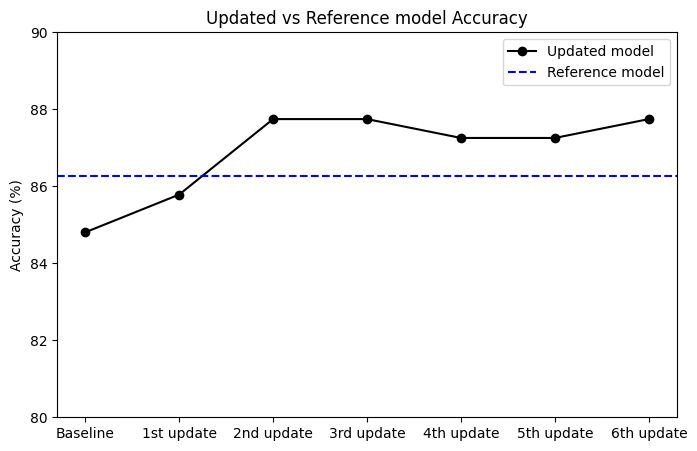

In [11]:
plt.figure(figsize=(8, 5))
plt.plot(range(7), updated_accuracy, marker='o', color='black',label='Updated model')
plt.axhline(y=ref_accuracy, color='blue', linestyle='--',label='Reference model')
plt.title('Updated vs Reference model Accuracy')
plt.ylabel('Accuracy (%)')
plt.xticks(range(7),['Baseline','1st update','2nd update','3rd update','4th update','5th update','6th update'])
plt.ylim(80, 90)
plt.legend()
plt.show()

In [12]:
print(round(ref_ce,3))
print(np.round(updated_ce,3))

0.347
[0.35  0.352 0.341 0.348 0.337 0.316 0.311]


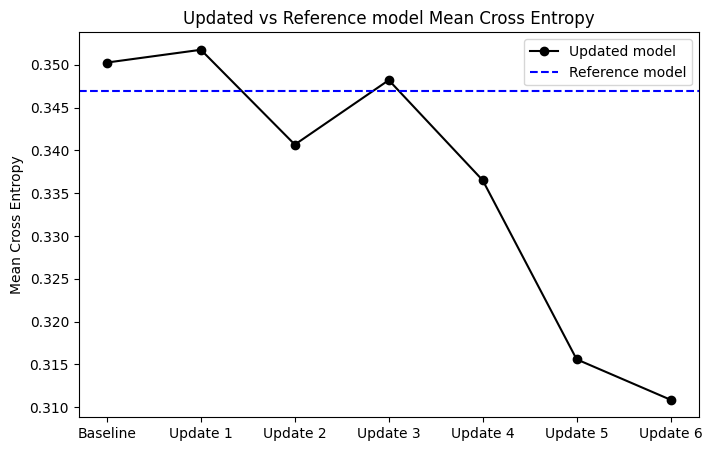

In [13]:
plt.figure(figsize=(8, 5))
plt.plot(range(7), updated_ce, marker='o', color='black',label='Updated model')
plt.axhline(y=ref_ce, color='blue', linestyle='--',label='Reference model')
plt.title('Updated vs Reference model Mean Cross Entropy')
plt.ylabel('Mean Cross Entropy')
#plt.ylim(0.55,0.75)
plt.xticks(range(7),['Baseline','Update 1','Update 2','Update 3','Update 4','Update 5','Update 6'])
plt.legend()
plt.show()


## 4-4. Reference Model vs. Updated Model

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

compare_ref_updated=df_test[['ID','survey_block','run','cost_diff','ivt_diff','ovt_fmlm_diff','ovt_transfer_diff','choice']]

compare_ref_updated['ref_prob']=ref_prob
compare_ref_updated['ref_choice']=ref_choice
compare_ref_updated['updated_prob']=updated_prob
compare_ref_updated['updated_choice']=updated_choice

compare_ref_updated['ref_result']=(compare_ref_updated['choice']==compare_ref_updated['ref_choice'])
compare_ref_updated['updated_result']=(compare_ref_updated['choice']==compare_ref_updated['updated_choice'])

compare_ref_updated['result'] = compare_ref_updated.apply(
    lambda row: 'Both correct' if row['ref_result'] == 1 and row['updated_result'] == 1
    else 'Only ref correct' if row['ref_result'] == 1 and row['updated_result'] == 0
    else 'Only updated correct' if row['ref_result'] == 0 and row['updated_result'] == 1
    else 'Neither correct', axis=1
)
compare_ref_updated['result'].value_counts()

,count
result,
Both correct,168
Neither correct,17
Only updated correct,11
Only ref correct,8


### 4-4-1. Error 비교

In [ ]:
compare_all_case = compare_ref_updated.copy()

In [ ]:
# 교차 엔트로피는 예측 확률 분포가 실제 분포에 얼마나 가까운지를 평가하므로, 확률 기반 분류 문제

def cross_entropy_loss(y_true, y_pred):
    sum_cross_entropy = 0
    for i in range(len(y_true)):
      if y_true[i] ==1:
        cross_entropy = -np.log(y_pred[i])
        sum_cross_entropy += cross_entropy
      else:
        cross_entropy = -np.log(1-y_pred[i])
        sum_cross_entropy += cross_entropy

    mean_loss = sum_cross_entropy / len(y_true)
    return mean_loss

print('\nReference model mean CE:',round(cross_entropy_loss(compare_all_case['choice'],compare_all_case['ref_prob']),4))
print('Updated model mean CE:',round(cross_entropy_loss(compare_all_case['choice'],compare_all_case['updated_prob']),4)) # 더 작음


Reference model mean CE: 0.3469
Updated model mean CE: 0.3109


In [ ]:
# 둘다 맞은 케이스에 대하여
# 똑같이 맞혀도 updated model이 error가 더 작게 맞췄다고 해석가능
both_correct_case = compare_ref_updated[compare_ref_updated['result']=='Both correct'].reset_index(drop=True)
print('\nReference model mean CE:',round(cross_entropy_loss(both_correct_case['choice'],both_correct_case['ref_prob']),4))
print('Updated model mean CE:',round(cross_entropy_loss(both_correct_case['choice'],both_correct_case['updated_prob']),4)) # 더 작음


Reference model mean CE: 0.1932
Updated model mean CE: 0.1137


In [ ]:
# 둘다 틀린 케이스에 대하여
# 한계(?) : 똑같이 틀렸을 때는 오히려 ref.model이 error가 더 작게 틀렸다고 해석가능
# 하지만 둘다 틀렸다는 것은 trash data일 가능성도 무시할 수 없음
neither_correct_case = compare_ref_updated[compare_ref_updated['result']=='Neither correct'].reset_index(drop=True)

print('\nReference model mean CE:',round(cross_entropy_loss(neither_correct_case['choice'],neither_correct_case['ref_prob']),4))
print('Updated model mean CE:',round(cross_entropy_loss(neither_correct_case['choice'],neither_correct_case['updated_prob']),4)) # 더 작음


Reference model mean CE: 1.4749
Updated model mean CE: 1.9641


### 4-4-2. Survey Block별 정오 분포

In [ ]:
survey_block_result_distribution = compare_ref_updated.groupby(['survey_block', 'result']).size().unstack(fill_value=0)
survey_block_result_distribution['Total'] = survey_block_result_distribution.sum(axis=1)
survey_block_result_distribution.loc['Total'] = survey_block_result_distribution.sum(axis=0)
survey_block_result_distribution

result,Both correct,Neither correct,Only ref correct,Only updated correct,Total
survey_block,,,,,
1,42,5,4,4,55
2,44,5,3,1,53
3,39,0,0,0,39
4,43,7,1,6,57
Total,168,17,8,11,204


In [ ]:
# survey_block별 result 분포를 테이블 형식으로 출력하고 총합 추가 (%로 봄)
survey_block_result_distribution = compare_ref_updated.groupby(['survey_block', 'result']).size().unstack(fill_value=0)
survey_block_result_distribution['Total'] = survey_block_result_distribution.sum(axis=1)
survey_block_result_distribution.loc['Total'] = survey_block_result_distribution.sum(axis=0)
survey_block_result_distribution['Both correct'] = (survey_block_result_distribution['Both correct']/survey_block_result_distribution['Total']*100).round(1)
survey_block_result_distribution['Neither correct'] = (survey_block_result_distribution['Neither correct']/survey_block_result_distribution['Total']*100).round(1)
survey_block_result_distribution['Only updated correct'] = (survey_block_result_distribution['Only updated correct']/survey_block_result_distribution['Total']*100).round(1)
survey_block_result_distribution['Only ref correct'] = (survey_block_result_distribution['Only ref correct']/survey_block_result_distribution['Total']*100).round(1)
survey_block_result_distribution

# 모든 survey block에서 ref_model과 updated_model의 예측 결과가 갈렸을 때, updated_model의 예측 결과가 맞을 확률이 더 높았다.
# 근거: 항상 only ref correct(%) < only updated correct(%)

result,Both correct,Neither correct,Only ref correct,Only updated correct,Total
survey_block,,,,,
1,76.4,9.1,7.3,7.3,55
2,83.0,9.4,5.7,1.9,53
3,100.0,0.0,0.0,0.0,39
4,75.4,12.3,1.8,10.5,57
Total,82.4,8.3,3.9,5.4,204


In [ ]:
for i in range(4):
  temp_df = compare_ref_updated[compare_ref_updated.survey_block==i+1]
  tot = len(temp_df)
  bc = len(temp_df[temp_df.result=='Both correct'])
  orc = len(temp_df[temp_df.result=='Only ref correct'])
  ouc = len(temp_df[temp_df.result=='Only updated correct'])
  print(f'\nblock {i+1}에 대한 updated model의 정답률: {(bc+ouc)/tot*100:.2f}%')
  print(f'block {i+1}에 대한 reference model의 정답률: {(bc+orc)/tot*100:.2f}%')


block 1에 대한 updated model의 정답률: 83.64%
block 1에 대한 reference model의 정답률: 83.64%

block 2에 대한 updated model의 정답률: 84.91%
block 2에 대한 reference model의 정답률: 88.68%

block 3에 대한 updated model의 정답률: 100.00%
block 3에 대한 reference model의 정답률: 100.00%

block 4에 대한 updated model의 정답률: 85.96%
block 4에 대한 reference model의 정답률: 77.19%


#  [5] Parameter Updating에 따른 Beta 분포 변화

In [ ]:
feature=['COST','IVT','OVT FMLM','OVT TRANSFER']
update_stage = ['1st update','2nd update','3rd update','4th update','5th update','6th update']

In [ ]:
def plot_updated_parameters(update_result, update_idx, binwidth=0.01):
  fig, axes = plt.subplots(2,3, figsize=(10,5))
  fig.suptitle(f'Distribution of Updated parameters for {feature[update_idx]}',fontsize=13)

  # x축 범위 설정하기 위하여
  x_min = update_result['update_6'].min()
  x_max = update_result['update_6'].max()
  # y축 범위 설정하기 위하여 1st stage만 그리기
  i, row, col = 1,0,0
  hist = sns.histplot(update_result[f'update_{i}'], binwidth=binwidth, color='grey', kde=True, ax=axes[row, col],stat='probability')
  axes[row,col].axvline(x= baseline_result.params.values[update_idx], ymin=-0, ymax=1, color='#41b8d5', linestyle='--', label='baseline')
  axes[row,col].axvline(x= reference_result.params.values[update_idx], ymin=-0, ymax=1, color='#0f4662', linestyle='--', label='reference')
  axes[row, col].set_title(f'{update_stage[i-1]}',fontsize=10)
  axes[row, col].set_xlim(x_min, x_max)
  axes[row, col].set_xlabel('')
  y_max = hist.get_ylim()[1]

  axes[row, col].legend(loc='upper left', fontsize=7)

  for i in range(2,7):
    row = (i - 1) // 3
    col = (i - 1) % 3
    sns.histplot(update_result[f'update_{i}'], binwidth=binwidth, color='grey', kde=True, ax=axes[row, col],stat='probability')
    axes[row,col].axvline(x= baseline_result.params.values[update_idx], ymin=-0, ymax=1, color='#41b8d5', linestyle='--', label='baseline')
    axes[row,col].axvline(x= reference_result.params.values[update_idx], ymin=-0, ymax=1, color='#0f4662', linestyle='--', label='reference')
    axes[row, col].set_title(f'{update_stage[i-1]}',fontsize=10)
    axes[row, col].set_xlim(x_min, x_max)
    axes[row, col].set_ylim(0, y_max)
    axes[row, col].set_xlabel('')
    if i!=4:
      axes[row,col].set_ylabel('')

  plt.tight_layout()
  #plt.show()
  plt.savefig(f'{feature[update_idx]}.png',dpi=200,transparent=True)

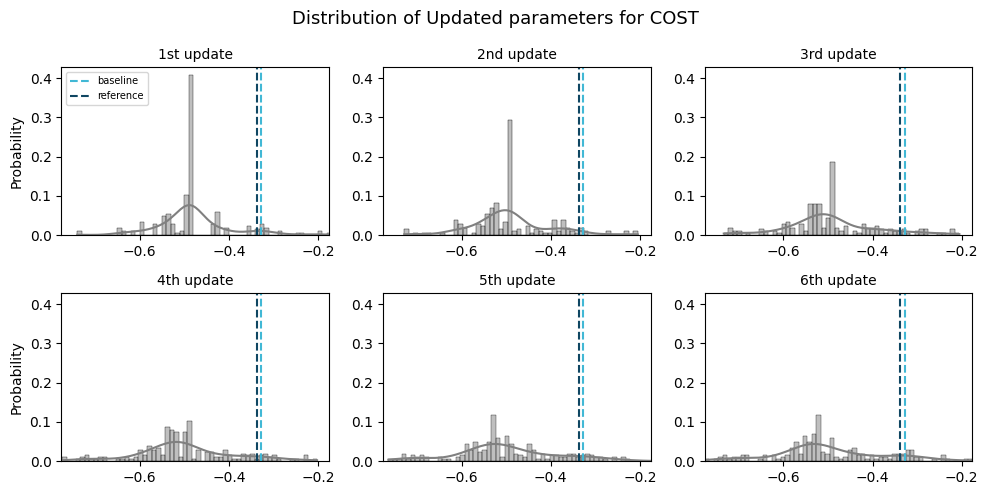

In [ ]:
plot_updated_parameters(cost_mean_update_result, 0 )

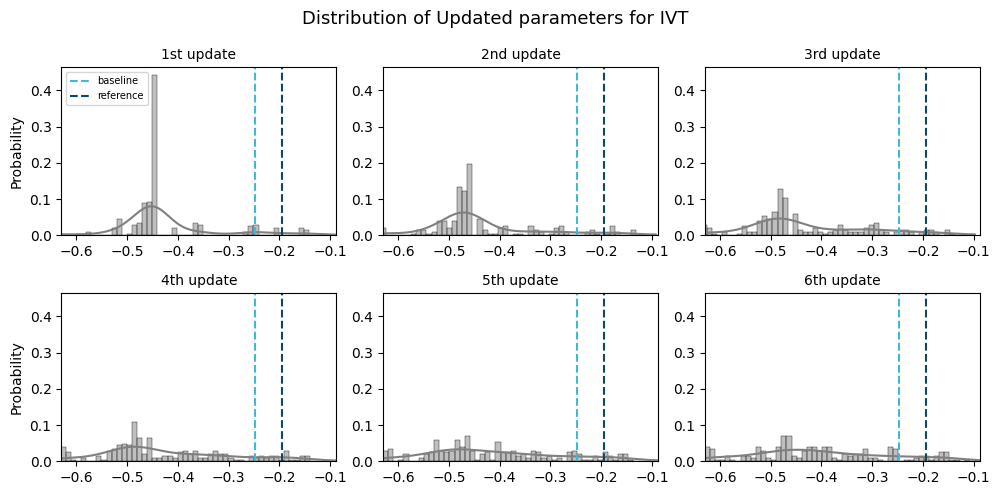

In [ ]:
plot_updated_parameters(ivt_mean_update_result,1)

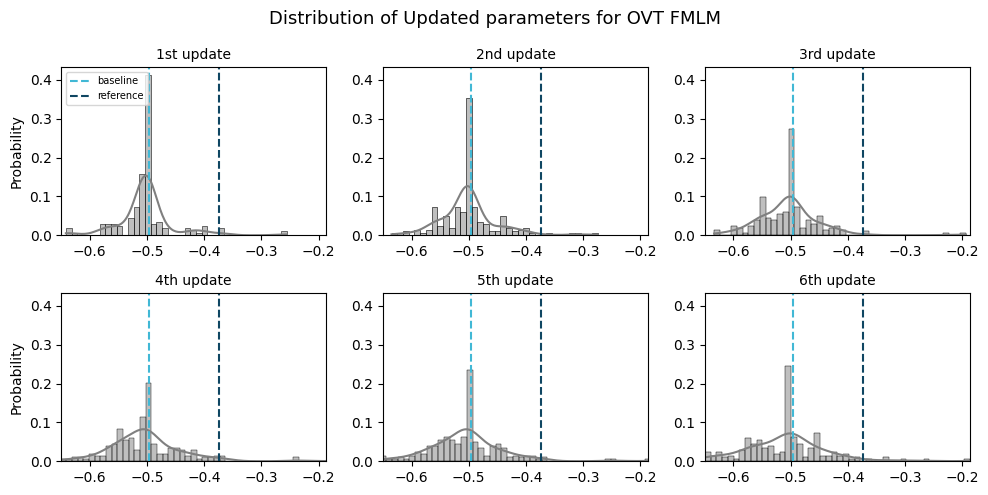

In [ ]:
plot_updated_parameters(ovt_fmlm_mean_update_result,2)

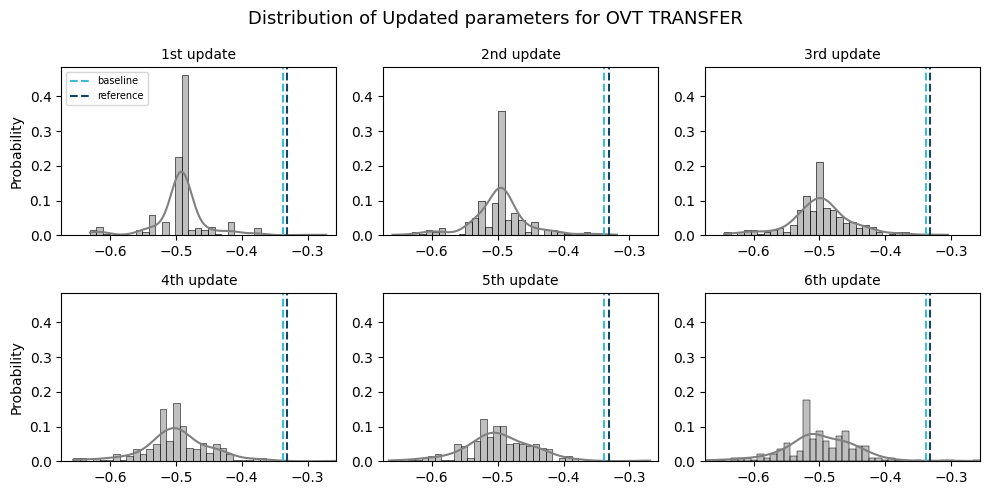

In [ ]:
plot_updated_parameters(ovt_transfer_mean_update_result,3)

## 5-1. Case study

In [ ]:
# 한 사람의 계수 변화 보여주는 함수
def plot_updated_parameters(update_result, id):
  fig, axs=plt.subplots(2,2,figsize=(14,10))
  fig.suptitle(f"Time series of Updates for ID {id}")
  for i in range(4):
    data_row = update_result[i][update_result[i]['ID'] == id]
    stages = data_row.columns[1:]
    values = data_row.iloc[0, 1:]

    ax = axs[i // 2, i % 2]
    ax. plot(stages, values, marker='o')
    ax.set_title(feature[i])
    ax.axhline(y=reference_result.params.values[i], color = 'red', linestyle='-',label='reference')
    ax.axhline(y=baseline_result.params.values[i],color='blue', linestyle='-',label='baseline')
    ax.set_ylim(-1,0)
    ax.legend(loc='upper left', fontsize=7)
    print(feature[i])
    print('reference',np.round(reference_result.params.values[i],4))
    print('baseline',np.round(baseline_result.params.values[i],4))
    print('updated',np.round(list(values),4))
    print('')

  plt.tight_layout(rect=[0, 0, 1, 0.95])  # 전체 제목과 subplot 사이 여백 설정
  plt.show()

## prob의 변화를 보여주자
def plot_prob_change(update_result, id):
  updated_prob=[]
  for i in range(1,8):
    beta_cost = update_result[0].iloc[id, i]
    beta_ivt = update_result[1].iloc[id, i]
    beta_ovt_fmlm = update_result[2].iloc[id,i]
    beta_ovt_transfer = update_result[3].iloc[id,i]

    df_test_ID = df_test[df_test.ID==id][['cost_diff', 'ivt_diff', 'ovt_fmlm_diff', 'ovt_transfer_diff', 'choice']].reset_index(drop=True)
    features = list(df_test_ID.iloc[0,0:4].values)
    cost_diff, ivt_diff, ovt_fmlm_diff, ovt_transfer_diff = features

    u_diff = beta_cost*cost_diff + beta_ivt*ivt_diff + beta_ovt_fmlm*ovt_fmlm_diff + beta_ovt_transfer*ovt_transfer_diff
    prob = 1 / (1+np.exp(-u_diff)) # A 선택 확률

    updated_prob.append(prob)

  print('reference',np.round(compare_ref_updated[compare_ref_updated['ID']==id]['ref_prob'].values,2))
  print('updated',np.round(updated_prob,2))
  plt.figure(figsize=(8,5))
  plt.plot(updated_prob, label='updated')
  plt.axhline(y=compare_ref_updated[compare_ref_updated['ID']==id]['ref_prob'].values, color = 'red', linestyle='-', label='reference')
  plt.axhline(y=0.5, linestyle='--', color='grey')
  plt.xticks([0,1,2,3,4,5,6],['baseline','update_1','update_2','update_3','update_4','update_5','update_6'])
  plt.xlabel('update stage')
  plt.ylabel('prob')
  plt.ylim(0,1.1)
  plt.title('Compare probability for choice: route A')
  plt.legend()
  plt.show()


# def case_study(block_num,update_result=mean_df_list):
#   temp_df = compare_ref_updated[compare_ref_updated.survey_block==block_num]
#   cases = ['Both correct', 'Neither correct', 'Only updated correct', 'Only ref correct']
#
#   for case in cases:
#     try:
#       if (block_num==4)&(case=='Both correct' or case=='Only ref correct'):
#         ID = temp_df[temp_df.result==case].sort_values(by='updated_prob').tail(1).reset_index()['ID'][0]
#       elif block_num==4:
#         ID = temp_df[temp_df.result==case].sort_values(by='updated_prob').head(1).reset_index()['ID'][0]
#       elif (case=='Both correct' or case=='Only ref correct'):
#         ID = temp_df[temp_df.result==case].sort_values(by='updated_prob').head(1).reset_index()['ID'][0]
#       else:
#         ID = temp_df[temp_df.result==case].sort_values(by='updated_prob').tail(1).reset_index()['ID'][0]
#     except:
#       continue
#
#     print(f'\n\nCase Study of Survey Block {block_num} - ID {ID} : {case}')
#     plot_updated_parameters(update_result,ID)
#     plot_prob_change(update_result,ID)
#

-> 이거 나중에 같은 질문끼리 묶어서 다시 봐야함 (4-8끼리, 4-3끼리.. )

In [ ]:
compare_ref_updated[['survey_block','run']].value_counts().head()

,,count
survey_block,run,
2,2,12
4,6,11
2,8,11
1,4,10
4,7,8


In [ ]:
pd.pivot_table(index=['survey_block','run'],columns='result',values='ID',aggfunc='count',data=compare_ref_updated).fillna(0).reindex(columns=['Both correct','Only updated correct','Only ref correct','Neither correct'])
# 1-4 (5/3/1/1)
# 1-8 (2/1/3/0)
# 2-8 (6/1/3/1)
# 4-3 (4/1/0/2)
# 4-7 (3/4/0/1)
# 4-8 (3/1/1/1)

result            Both correct  Only updated correct  Only ref correct  \
survey_block run                                                         
1            1             7.0                   0.0               0.0   
             2             6.0                   0.0               0.0   
             3             3.0                   0.0               0.0   
             4             5.0                   3.0               1.0   
             5             6.0                   0.0               0.0   
             6             6.0                   0.0               0.0   
             7             7.0                   0.0               0.0   
             8             2.0                   1.0               3.0   
2            1             6.0                   0.0               0.0   
             2            11.0                   0.0               0.0   
             3             2.0                   0.0               0.0   
             4             6.0                   0.0               0.0   
             5             4.0                   0.0               0.0   
             6             6.0                   0.0               0.0   
             7             3.0                   0.0               0.0   
             8             6.0                   1.0               3.0   
3            1             3.0                   0.0               0.0   
             2             5.0                   0.0               0.0   
             3             6.0                   0.0               0.0   
             4             1.0                   0.0               0.0   
             5             7.0                   0.0               0.0   
             6             8.0                   0.0               0.0   
             7             6.0                   0.0               0.0   
             8             3.0                   0.0               0.0   
4            1             5.0                   0.0               0.0   
             2             6.0                   0.0               0.0   
             3             4.0                   1.0               0.0   
             4             7.0                   0.0               0.0   
             5             5.0                   0.0               0.0   
             6            10.0                   0.0               0.0   
             7             3.0                   4.0               0.0   
             8             3.0                   1.0               1.0   

result            Neither correct  
survey_block run                   
1            1                0.0  
             2                0.0  
             3                1.0  
             4                1.0  
             5                0.0  
             6                2.0  
             7                1.0  
             8                0.0  
2            1                0.0  
             2                1.0  
             3                0.0  
             4                0.0  
             5                0.0  
             6                1.0  
             7                2.0  
             8                1.0  
3            1                0.0  
             2                0.0  
             3                0.0  
             4                0.0  
             5                0.0  
             6                0.0  
             7                0.0  
             8                0.0  
4            1                0.0  
             2                2.0  
             3                2.0  
             4                0.0  
             5                0.0  
             6                1.0  
             7                1.0  
             8                1.0

In [ ]:
df_test[['survey_block','run','cost_diff','ivt_diff','ovt_fmlm_diff','ovt_transfer_diff']].drop_duplicates().sort_values(by=['survey_block','run'])

,survey_block,run,cost_diff,ivt_diff,ovt_fmlm_diff,ovt_transfer_diff
89,1,1,7.5,15,-2,0
4,1,2,0.0,0,4,2
15,1,3,-2.5,-10,0,6
21,1,4,2.5,0,2,-4
18,1,5,0.0,-5,0,-2
8,1,6,-7.5,-5,4,2
19,1,7,0.0,-5,-2,0
2,1,8,0.0,10,-6,-4
36,2,1,5.0,-15,2,-6
5,2,2,-5.0,5,2,-6


### (1) updated model만 정답인 경우

In [ ]:
compare_ref_updated[(compare_ref_updated.survey_block==4)&(compare_ref_updated.result=='Only updated correct')]

,ID,survey_block,run,cost_diff,ivt_diff,ovt_fmlm_diff,ovt_transfer_diff,choice,ref_prob,ref_choice,updated_prob,updated_choice,ref_result,updated_result,result
13,13,4,7,-5.0,10,0,0,1,0.435010,0,0.886292,1,False,True,Only updated correct
92,92,4,7,-5.0,10,0,0,1,0.435010,0,0.724240,1,False,True,Only updated correct
111,111,4,3,5.0,0,-2,-2,1,0.430777,0,0.557660,1,False,True,Only updated correct
149,149,4,7,-5.0,10,0,0,1,0.435010,0,0.739076,1,False,True,Only updated correct
167,167,4,7,-5.0,10,0,0,1,0.435010,0,0.870583,1,False,True,Only updated correct
190,190,4,8,-5.0,0,6,-2,0,0.528097,1,0.443492,0,False,True,Only updated correct


reference [0.44]
updated [0.3  0.89 0.85 0.89 0.89 0.89 0.89]


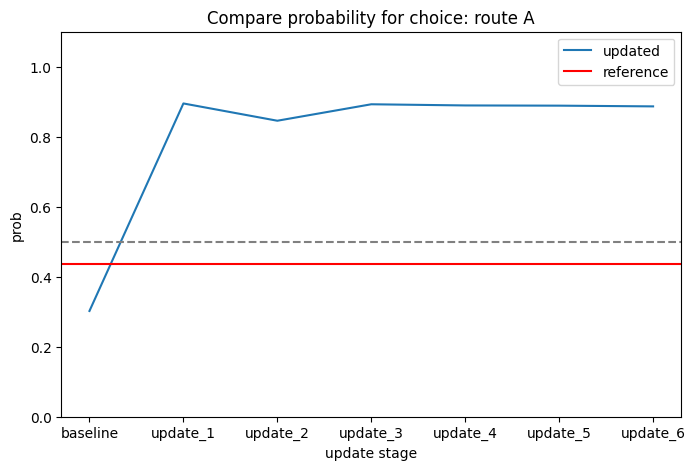

cost
reference -0.3377
baseline -0.3279
updated [-0.3279 -0.7405 -0.7018 -0.7193 -0.725  -0.7311 -0.7317]

ivt
reference -0.195
baseline -0.2479
updated [-0.2479 -0.1563 -0.1811 -0.1482 -0.1545 -0.1581 -0.1605]

ovt_fmlm
reference -0.3732
baseline -0.496
updated [-0.496  -0.3693 -0.4086 -0.4549 -0.4241 -0.4194 -0.4222]

ovt_transfer
reference -0.3316
baseline -0.3379
updated [-0.3379 -0.4908 -0.4938 -0.4563 -0.4703 -0.463  -0.4652]



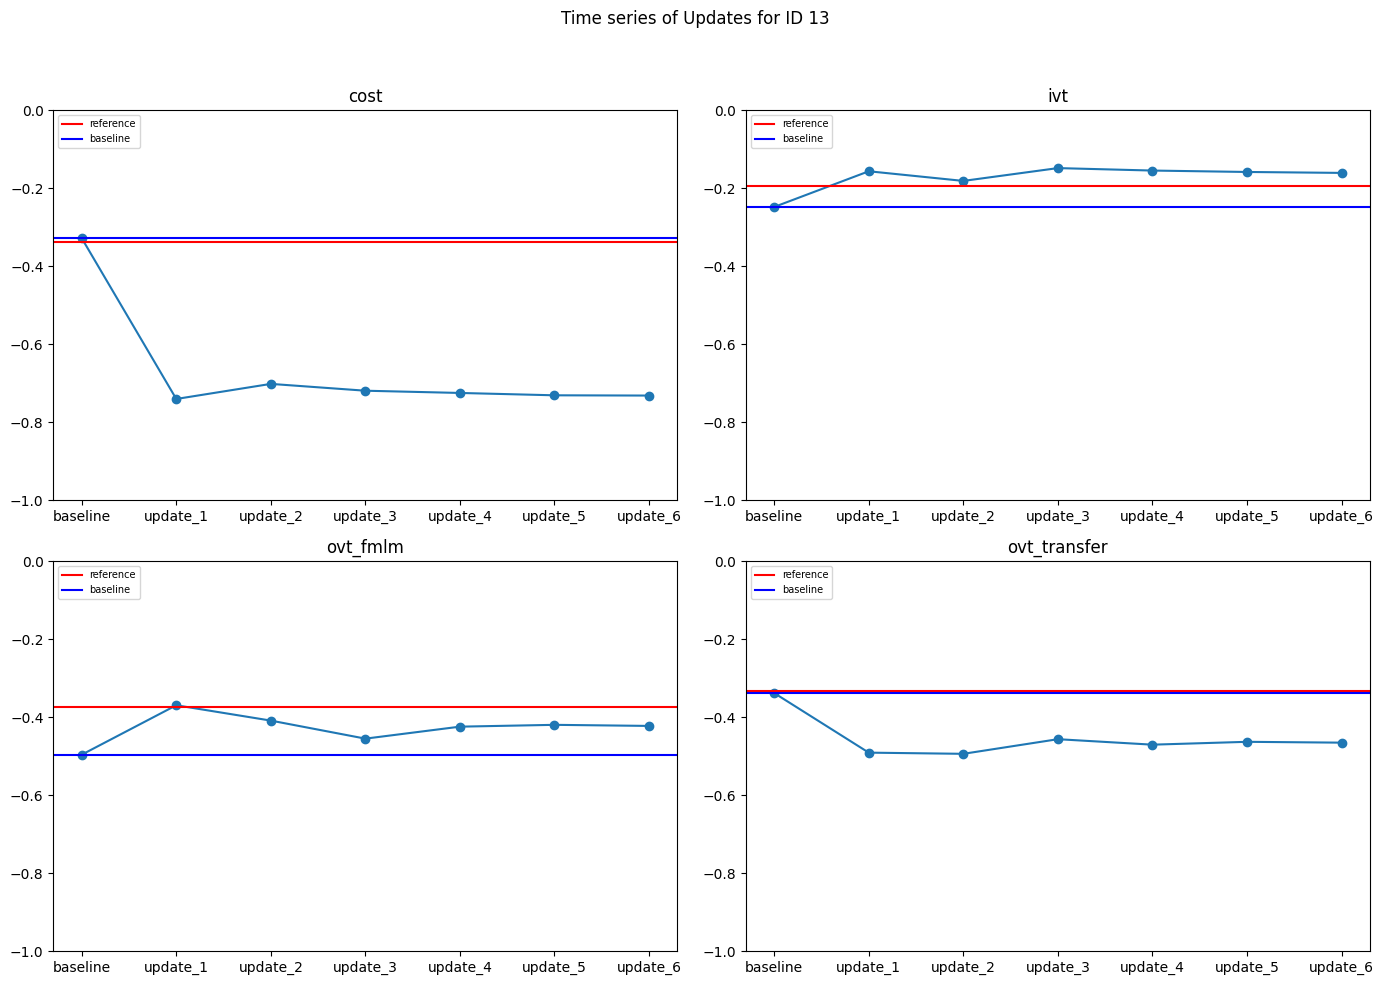

In [ ]:
# ID 13 / Only updated correct / survey block 4 & run 7 (얘는 근데 속성차이가 두 개나 0이네 .. )
# 실제선택 A
plot_prob_change(mean_df_list,13)
plot_updated_parameters(mean_df_list,13)

reference [0.43]
updated [0.51 0.47 0.49 0.44 0.57 0.56 0.56]


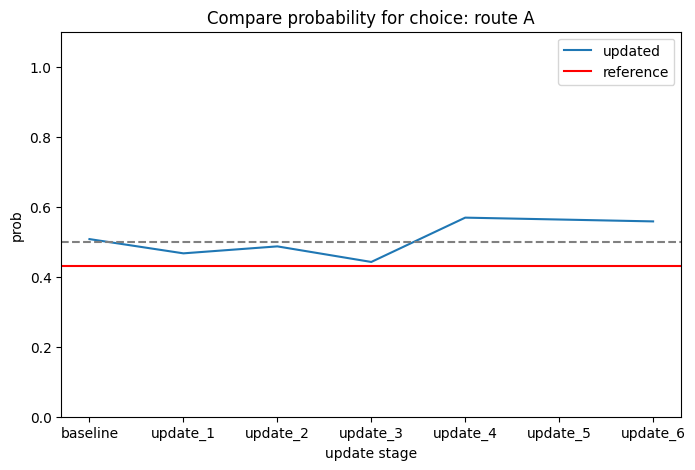

cost
reference -0.3377
baseline -0.3279
updated [-0.3279 -0.4249 -0.3768 -0.4173 -0.3407 -0.346  -0.3534]

ivt
reference -0.195
baseline -0.2479
updated [-0.2479 -0.4764 -0.6374 -0.6304 -0.6255 -0.6285 -0.626 ]

ovt_fmlm
reference -0.3732
baseline -0.496
updated [-0.496  -0.5042 -0.4364 -0.4443 -0.5341 -0.533  -0.538 ]

ovt_transfer
reference -0.3316
baseline -0.3379
updated [-0.3379 -0.4908 -0.478  -0.4818 -0.4554 -0.4588 -0.4613]



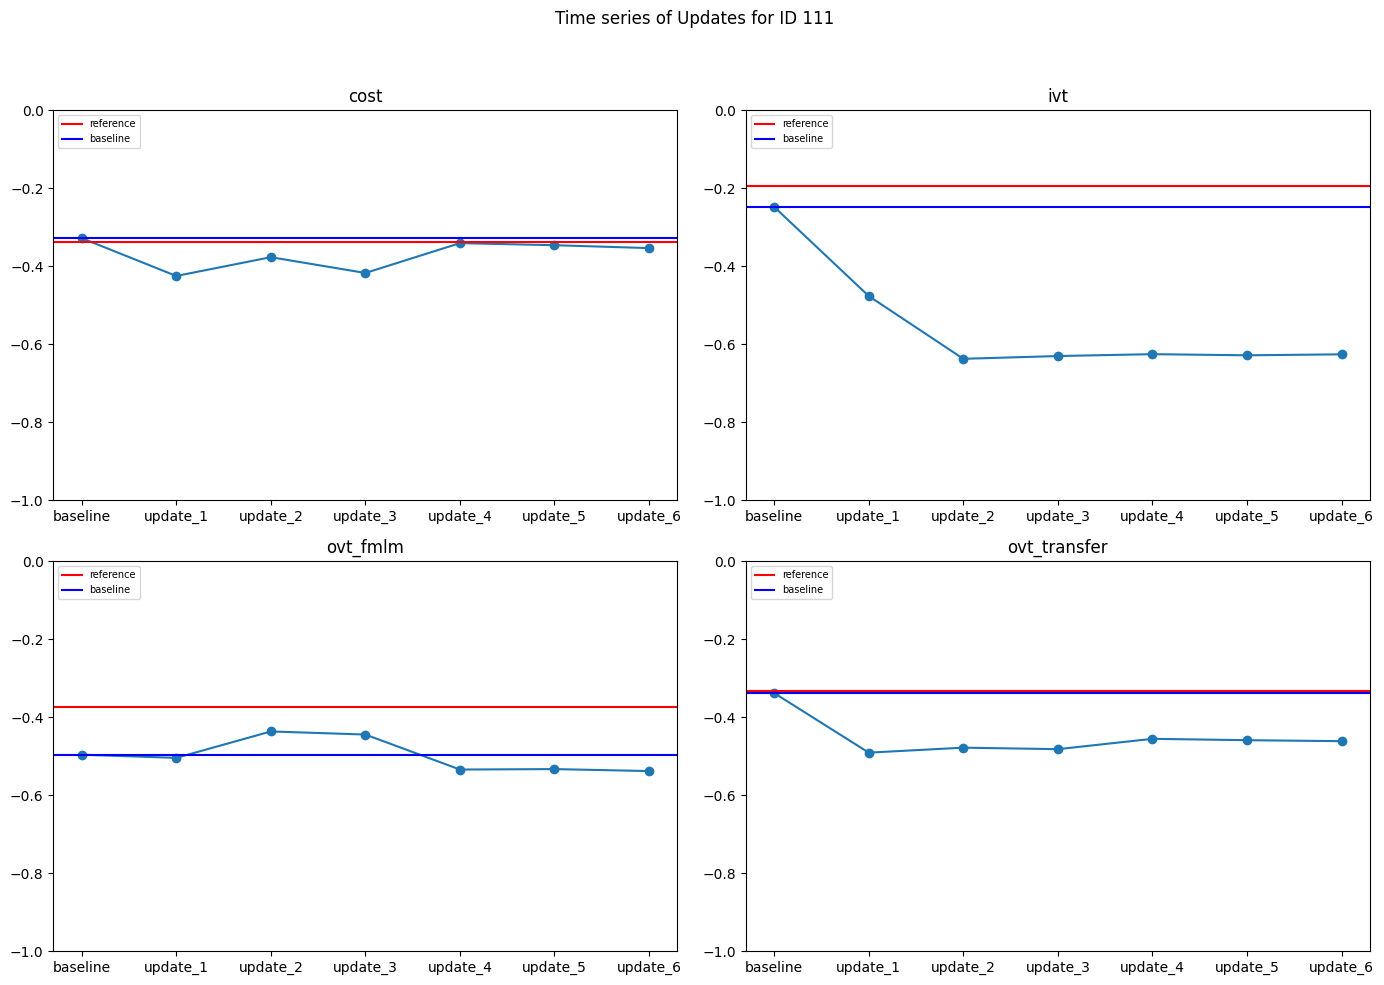

In [ ]:
# ID 111 / Only updated correct / survey block 4 & run 3 (아래 neither correct 보다가 뽑아봄)
# 실제 선택 A
plot_prob_change(mean_df_list,111)
plot_updated_parameters(mean_df_list,111)

reference [0.53]
updated [0.34 0.52 0.37 0.38 0.4  0.4  0.44]


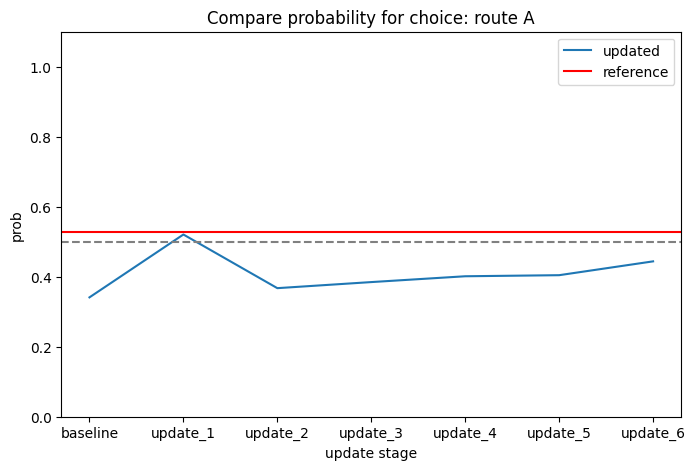

cost
reference -0.3377
baseline -0.3279
updated [-0.3279 -0.4249 -0.3335 -0.3533 -0.3605 -0.3601 -0.3383]

ivt
reference -0.195
baseline -0.2479
updated [-0.2479 -0.4764 -0.4826 -0.4853 -0.506  -0.5298 -0.6168]

ovt_fmlm
reference -0.3732
baseline -0.496
updated [-0.496  -0.5042 -0.5476 -0.5498 -0.5434 -0.5402 -0.4898]

ovt_transfer
reference -0.3316
baseline -0.3379
updated [-0.3379 -0.4908 -0.5363 -0.5302 -0.5282 -0.5259 -0.5104]



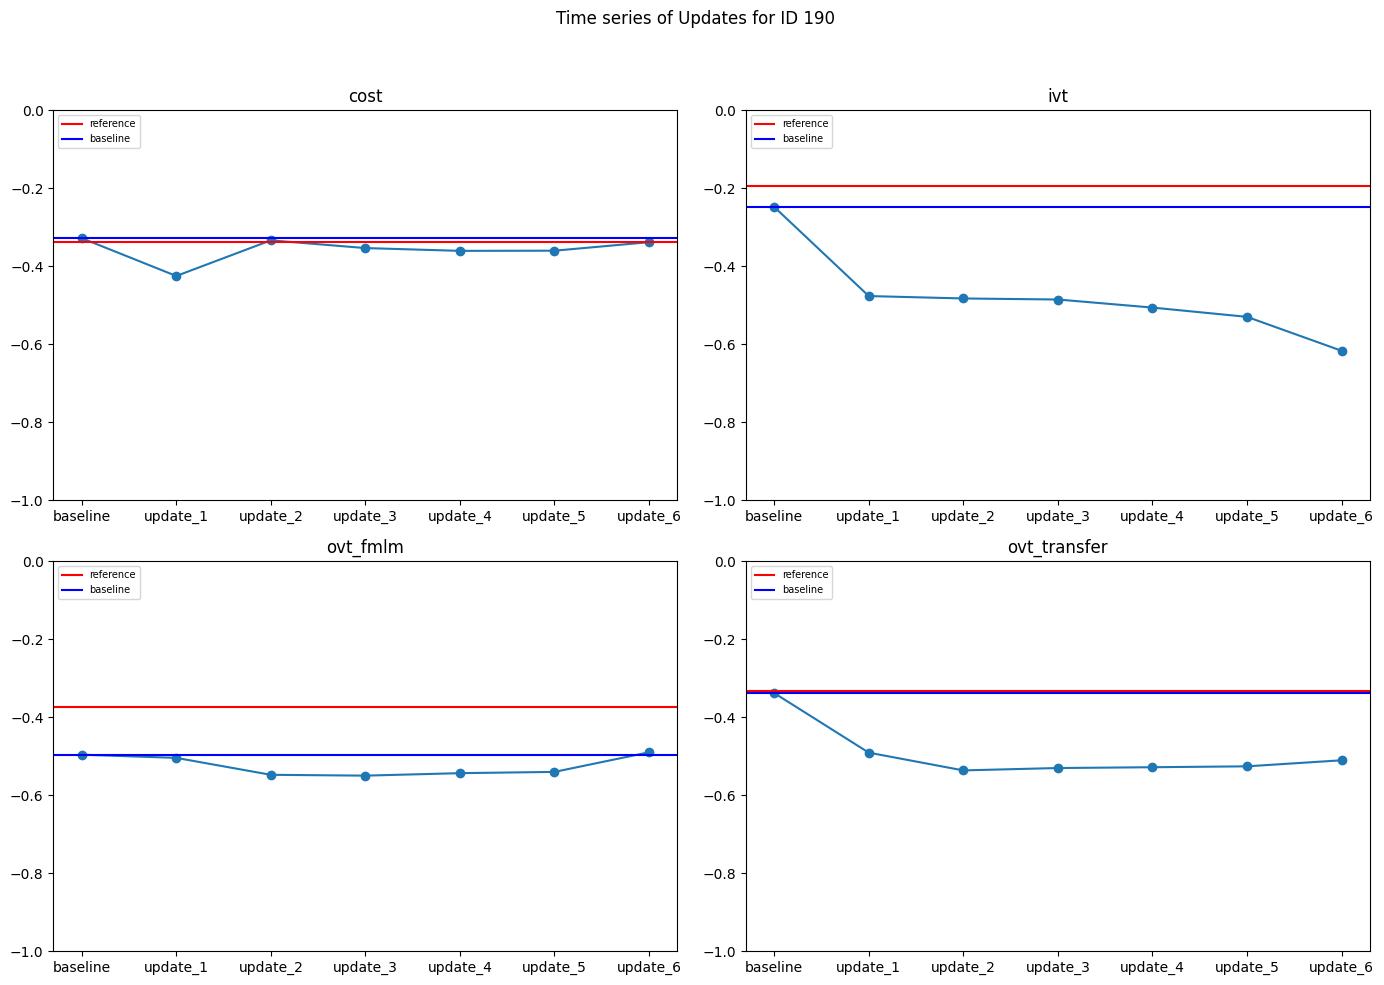

In [ ]:
# ID 190 / Only updated correct / survey block 4 & run 8
# 실제 선택 B
plot_prob_change(mean_df_list,190)
plot_updated_parameters(mean_df_list,190)

In [ ]:
compare_ref_updated[(compare_ref_updated.survey_block==2)&(compare_ref_updated.result=='Only updated correct')]

,ID,survey_block,run,cost_diff,ivt_diff,ovt_fmlm_diff,ovt_transfer_diff,choice,ref_prob,ref_choice,updated_prob,updated_choice,ref_result,updated_result,result
150,150,2,8,-5.0,5,-4,4,0,0.706743,1,0.491517,0,False,True,Only updated correct


reference [0.71]
updated [0.74 0.42 0.44 0.49 0.49 0.49 0.49]


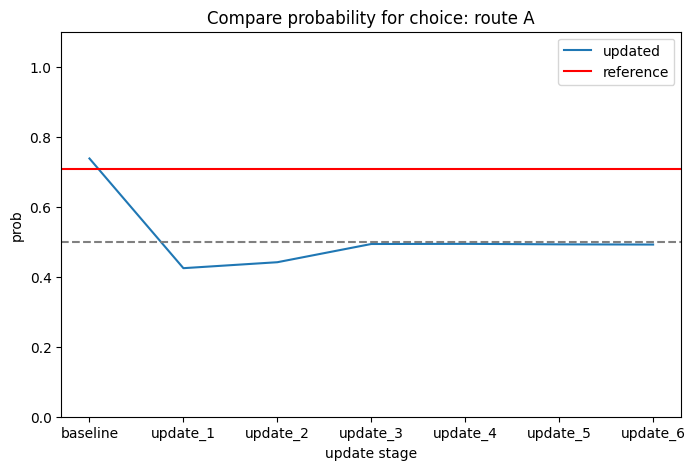

cost
reference -0.3377
baseline -0.3279
updated [-0.3279 -0.4041 -0.4342 -0.4856 -0.4869 -0.4878 -0.4887]

ivt
reference -0.195
baseline -0.2479
updated [-0.2479 -0.5131 -0.5184 -0.4792 -0.481  -0.4837 -0.4852]

ovt_fmlm
reference -0.3732
baseline -0.496
updated [-0.496  -0.5224 -0.5178 -0.5021 -0.5019 -0.5018 -0.5017]

ovt_transfer
reference -0.3316
baseline -0.3379
updated [-0.3379 -0.4627 -0.4718 -0.517  -0.5158 -0.5147 -0.5145]



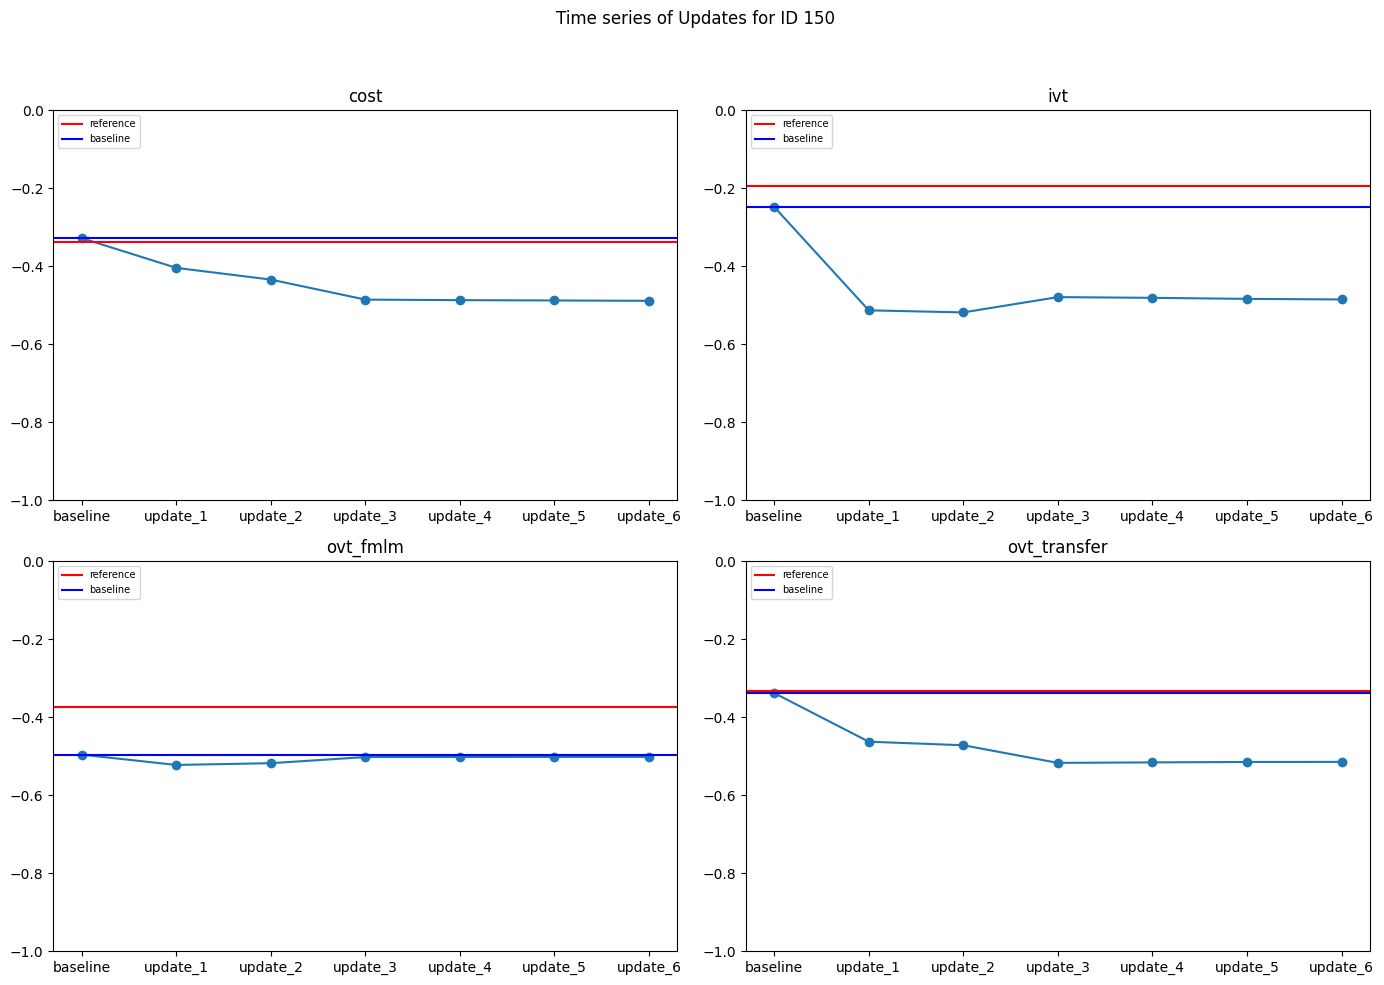

In [ ]:
# ID 150 / Only updated correct / survey block 2 & run 8
# 실제 선택 B
plot_prob_change(mean_df_list,150)
plot_updated_parameters(mean_df_list,150)

### (2) Both Correct인 경우

In [ ]:
df = compare_ref_updated[(compare_ref_updated.survey_block==4)&(compare_ref_updated.result=='Both correct')].reset_index(drop=True)
df['prob_diff'] = np.abs(df['ref_prob'] - df['updated_prob'])
df.sort_values(by='prob_diff',ascending=False).head()

,ID,survey_block,run,cost_diff,ivt_diff,ovt_fmlm_diff,ovt_transfer_diff,choice,ref_prob,ref_choice,updated_prob,updated_choice,ref_result,updated_result,result,prob_diff
4,14,4,7,-5.0,10,0,0,0,0.435010,0,0.009962,0,True,True,Both correct,0.425048
10,69,4,8,-5.0,0,6,-2,1,0.528097,1,0.904506,1,True,True,Both correct,0.376409
7,50,4,2,2.5,-10,6,2,0,0.142246,0,0.489075,0,True,True,Both correct,0.346829
39,181,4,3,5.0,0,-2,-2,0,0.430777,0,0.107669,0,True,True,Both correct,0.323107
5,32,4,7,-5.0,10,0,0,0,0.435010,0,0.117643,0,True,True,Both correct,0.317366


In [ ]:
# 181번에 대해서 질문순서를 알고 싶어
df_update[df_update.ID==181].sort_values(by='run_random')

,ID,survey_block,route_choice,male,age,income,run,A_ovt_fmlm,A_ivt,A_ovt_transfer,A_cost,B_ovt_fmlm,B_ivt,B_ovt_transfer,B_cost,choice,cost_diff,ivt_diff,ovt_fmlm_diff,ovt_transfer_diff,run_random
1091,181,4,경로 A,True,40세 이상,300 ~ 500만원,8,16,50,6,1750,10,50,8,2250,1,-5.0,0,6,-2,2
1086,181,4,경로 A,True,40세 이상,300 ~ 500만원,1,10,50,10,1500,14,50,10,1750,1,-2.5,0,-4,0,3
1090,181,4,경로 A,True,40세 이상,300 ~ 500만원,7,12,45,12,1750,12,35,12,2250,1,-5.0,10,0,0,4
1089,181,4,경로 B,True,40세 이상,300 ~ 500만원,6,10,35,12,2000,14,45,12,1500,0,5.0,-10,-4,0,5
1087,181,4,경로 B,True,40세 이상,300 ~ 500만원,2,16,35,8,2250,10,45,6,2000,0,2.5,-10,6,2,6
1088,181,4,경로 A,True,40세 이상,300 ~ 500만원,4,14,45,8,1500,16,35,6,1750,1,-2.5,10,-2,2,7


reference [0.43]
updated [0.51 0.2  0.23 0.15 0.11 0.11 0.11]


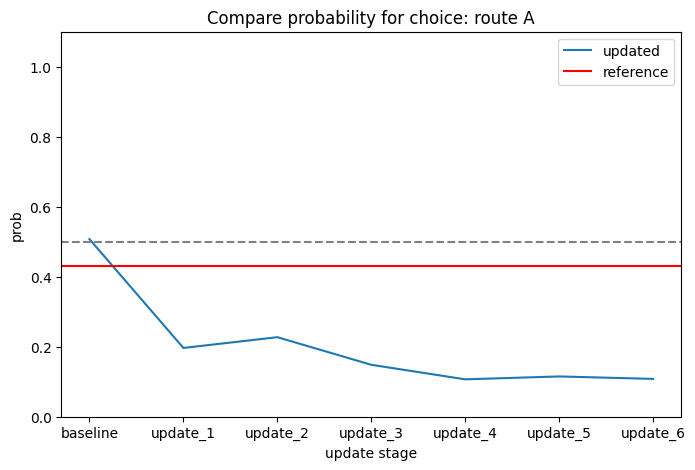

cost
reference -0.3377
baseline -0.3279
updated [-0.3279 -0.6344 -0.6107 -0.7194 -0.7739 -0.7643 -0.7763]

ivt
reference -0.195
baseline -0.2479
updated [-0.2479 -0.4448 -0.4609 -0.295  -0.2109 -0.2102 -0.1697]

ovt_fmlm
reference -0.3732
baseline -0.496
updated [-0.496  -0.3686 -0.4055 -0.4166 -0.3648 -0.3802 -0.4074]

ovt_transfer
reference -0.3316
baseline -0.3379
updated [-0.3379 -0.5121 -0.5082 -0.5067 -0.5059 -0.5087 -0.4761]



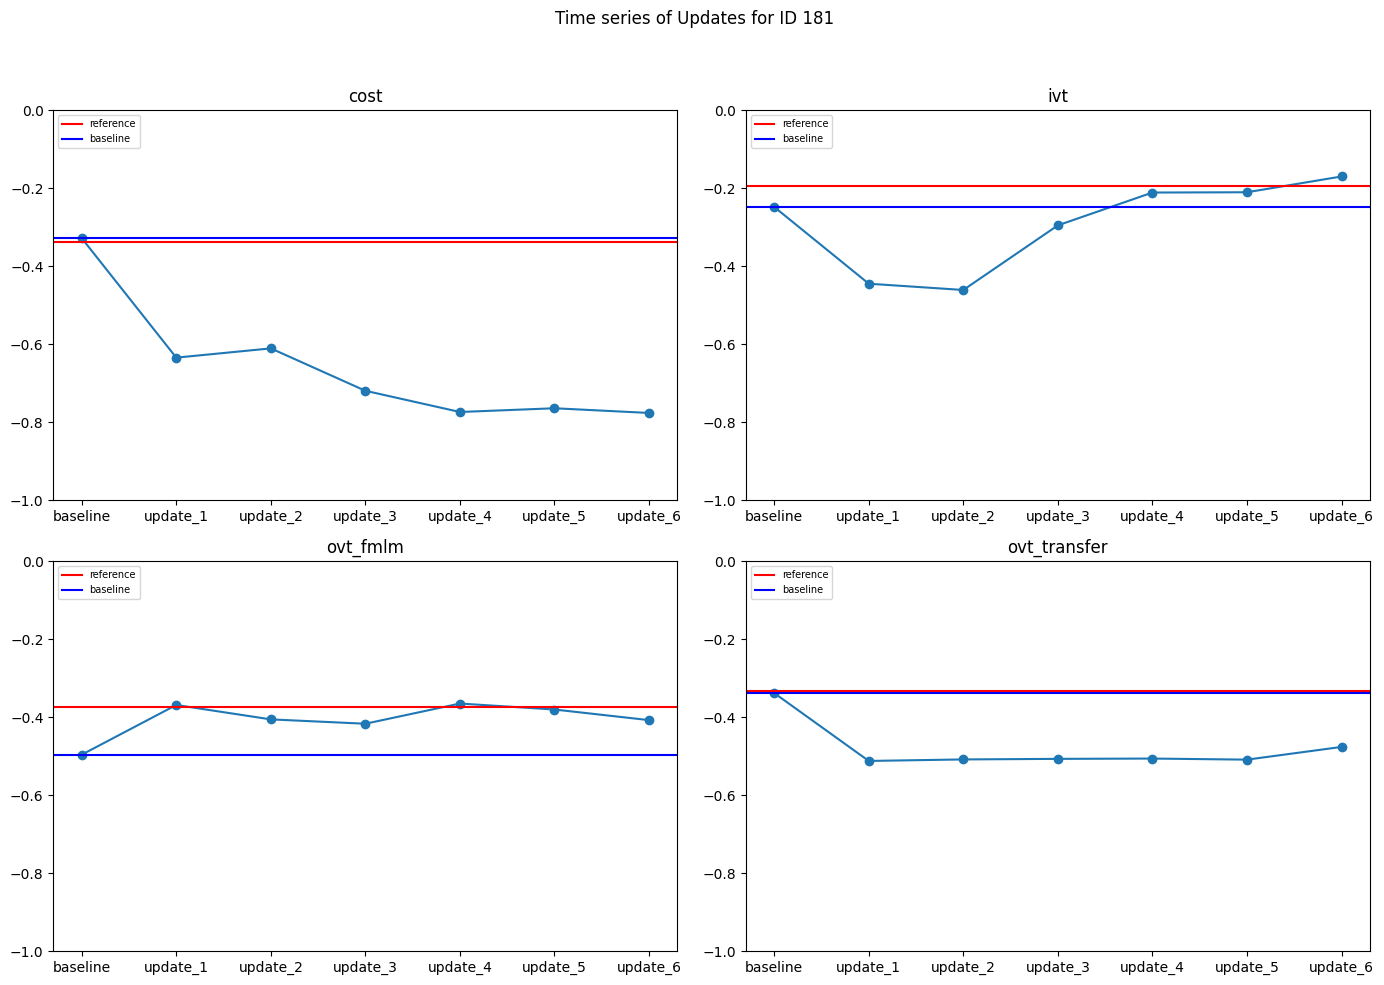

In [ ]:
# ID 181 / Both correct / survey block 4 & run 3
# 실제 선택 B
plot_prob_change(mean_df_list,181)
plot_updated_parameters(mean_df_list,181)

reference [0.53]
updated [0.34 0.73 0.72 0.9  0.93 0.9  0.9 ]


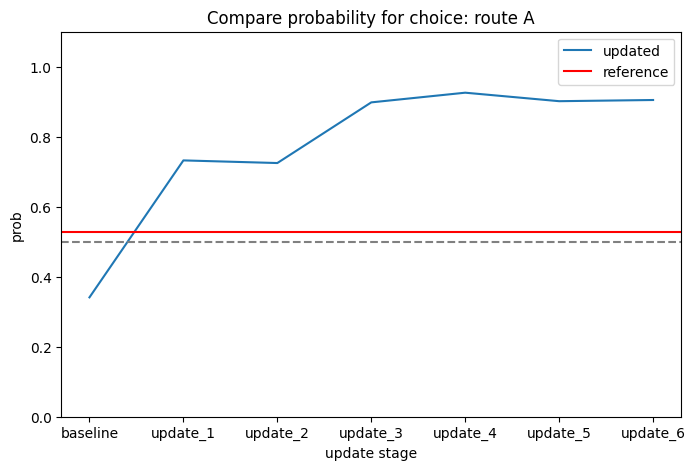

cost
reference -0.3377
baseline -0.3279
updated [-0.3279 -0.3115 -0.3297 -0.5118 -0.595  -0.5408 -0.5898]

ivt
reference -0.195
baseline -0.2479
updated [-0.2479 -0.4448 -0.5641 -0.3046 -0.2362 -0.2415 -0.1759]

ovt_fmlm
reference -0.3732
baseline -0.496
updated [-0.496  -0.2558 -0.2744 -0.2262 -0.2385 -0.2451 -0.2651]

ovt_transfer
reference -0.3316
baseline -0.3379
updated [-0.3379 -0.4908 -0.4821 -0.4853 -0.487  -0.4881 -0.4449]



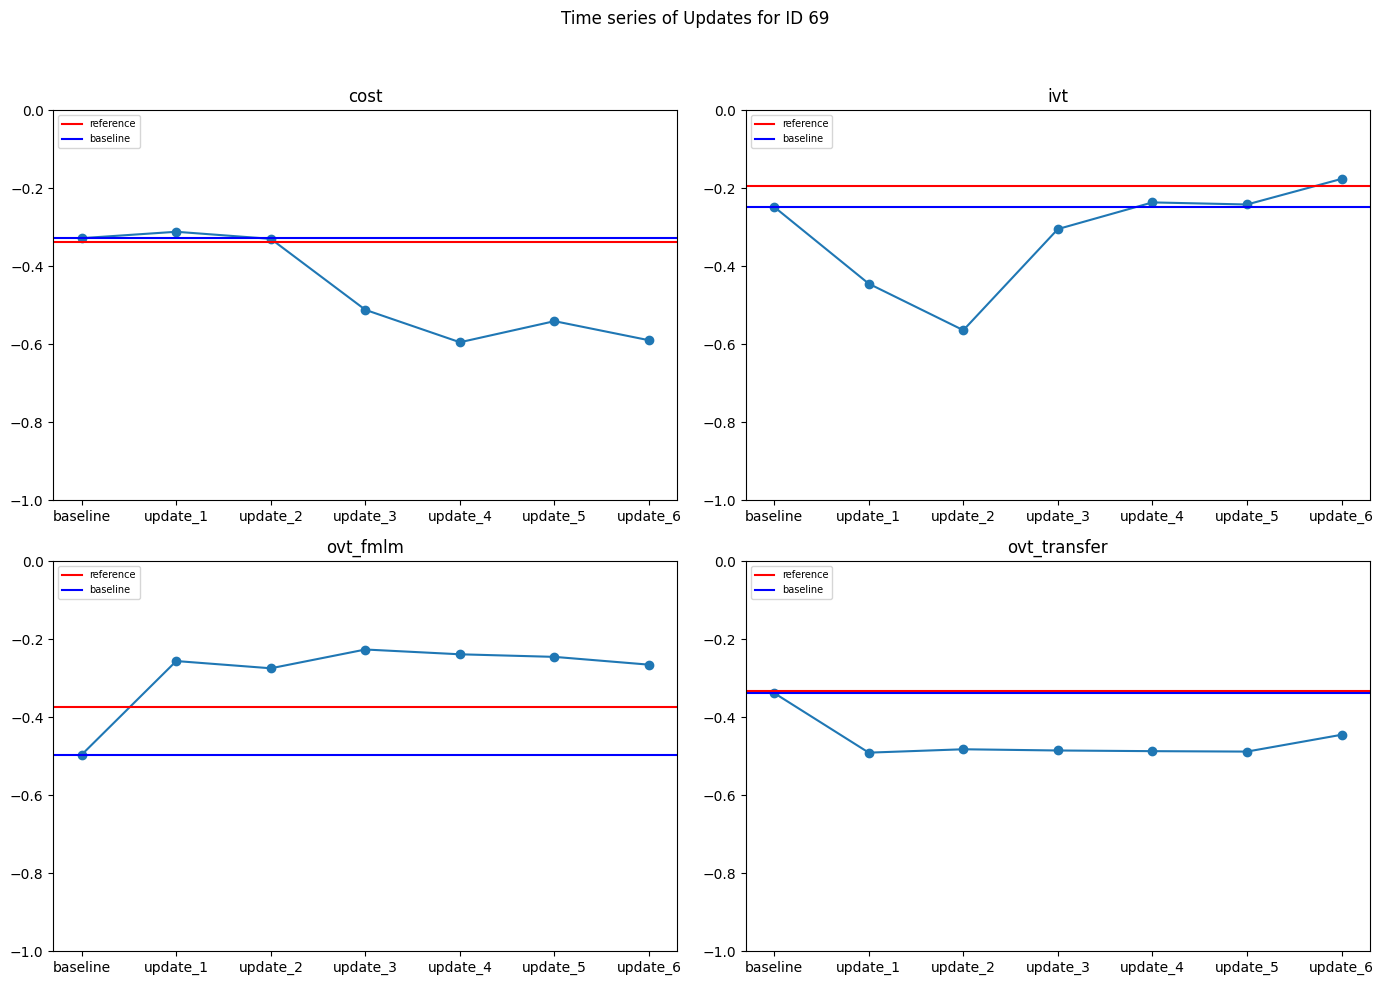

In [ ]:
# ID 69 / Both correct / survey block 4 & run 8
# 실제 선택 A
plot_prob_change(mean_df_list,69)
plot_updated_parameters(mean_df_list,69)

reference [0.14]
updated [0.12 0.3  0.32 0.33 0.37 0.46 0.49]


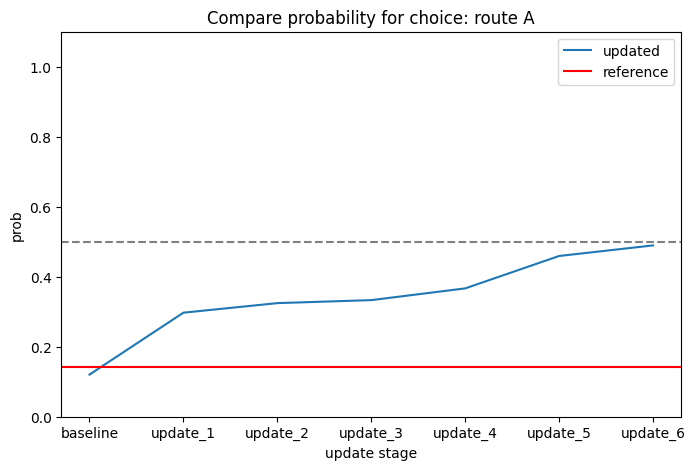

cost
reference -0.3377
baseline -0.3279
updated [-0.3279 -0.4919 -0.3642 -0.4025 -0.407  -0.4005 -0.4027]

ivt
reference -0.195
baseline -0.2479
updated [-0.2479 -0.4448 -0.4609 -0.4673 -0.4801 -0.5143 -0.5247]

ovt_fmlm
reference -0.3732
baseline -0.496
updated [-0.496  -0.5164 -0.559  -0.5494 -0.5456 -0.5421 -0.5386]

ovt_transfer
reference -0.3316
baseline -0.3379
updated [-0.3379 -0.4908 -0.5395 -0.5329 -0.5293 -0.5269 -0.5262]



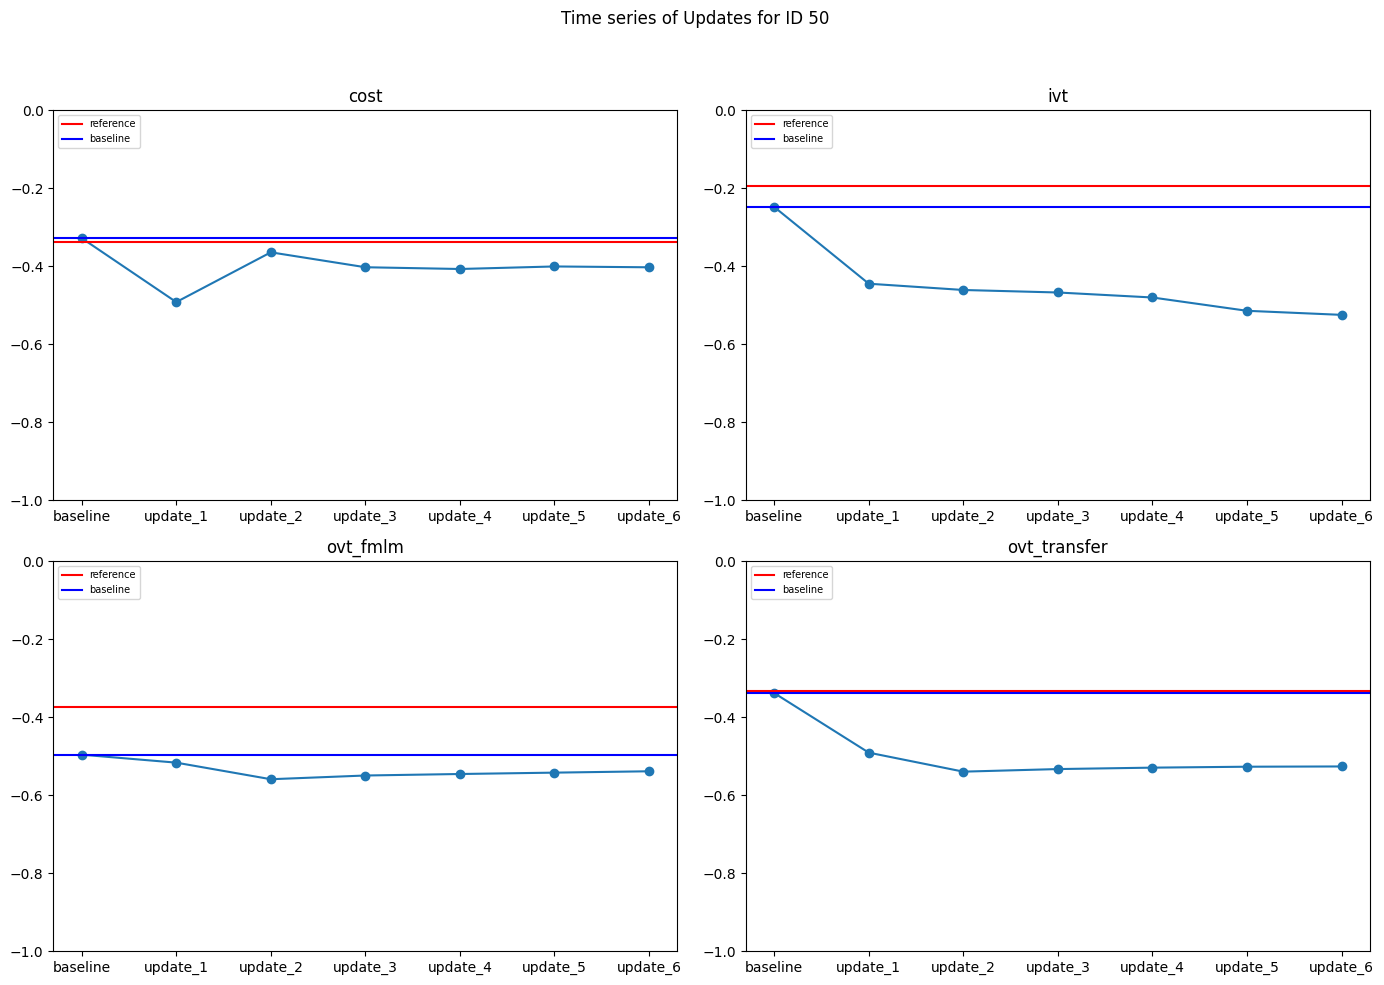

In [ ]:
# ID 50 / Both correct / survey block 4 & run 2 / 안 좋은 예시
# 실제 선택 B
plot_prob_change(mean_df_list,50)
plot_updated_parameters(mean_df_list,50)

In [ ]:
df = compare_ref_updated[(compare_ref_updated.survey_block==2)&(compare_ref_updated.result=='Both correct')].reset_index(drop=True)
df['prob_diff'] = np.abs(df['ref_prob'] - df['updated_prob'])
df.sort_values(by='prob_diff',ascending=False).head()

,ID,survey_block,run,cost_diff,ivt_diff,ovt_fmlm_diff,ovt_transfer_diff,choice,ref_prob,ref_choice,updated_prob,updated_choice,ref_result,updated_result,result,prob_diff
8,41,2,7,-2.5,5,2,-2,0,0.446751,0,0.083594,0,True,True,Both correct,0.363157
20,91,2,8,-5.0,5,-4,4,1,0.706743,1,0.954310,1,True,True,Both correct,0.247568
13,57,2,8,-5.0,5,-4,4,1,0.706743,1,0.952660,1,True,True,Both correct,0.245917
40,189,2,7,-2.5,5,2,-2,0,0.446751,0,0.286231,0,True,True,Both correct,0.160520
12,52,2,7,-2.5,5,2,-2,0,0.446751,0,0.338405,0,True,True,Both correct,0.108346


reference [0.45]
updated [0.32 0.26 0.25 0.07 0.08 0.08 0.08]


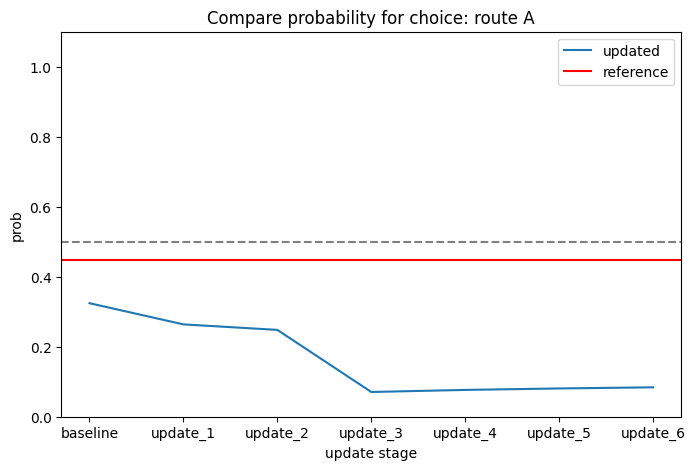

cost
reference -0.3377
baseline -0.3279
updated [-0.3279 -0.4875 -0.4915 -0.3287 -0.3446 -0.3528 -0.3584]

ivt
reference -0.195
baseline -0.2479
updated [-0.2479 -0.4461 -0.4656 -0.6072 -0.6027 -0.5992 -0.5964]

ovt_fmlm
reference -0.3732
baseline -0.496
updated [-0.496  -0.4998 -0.4999 -0.5552 -0.5503 -0.5464 -0.5436]

ovt_transfer
reference -0.3316
baseline -0.3379
updated [-0.3379 -0.4914 -0.4941 -0.3711 -0.3789 -0.3847 -0.3892]



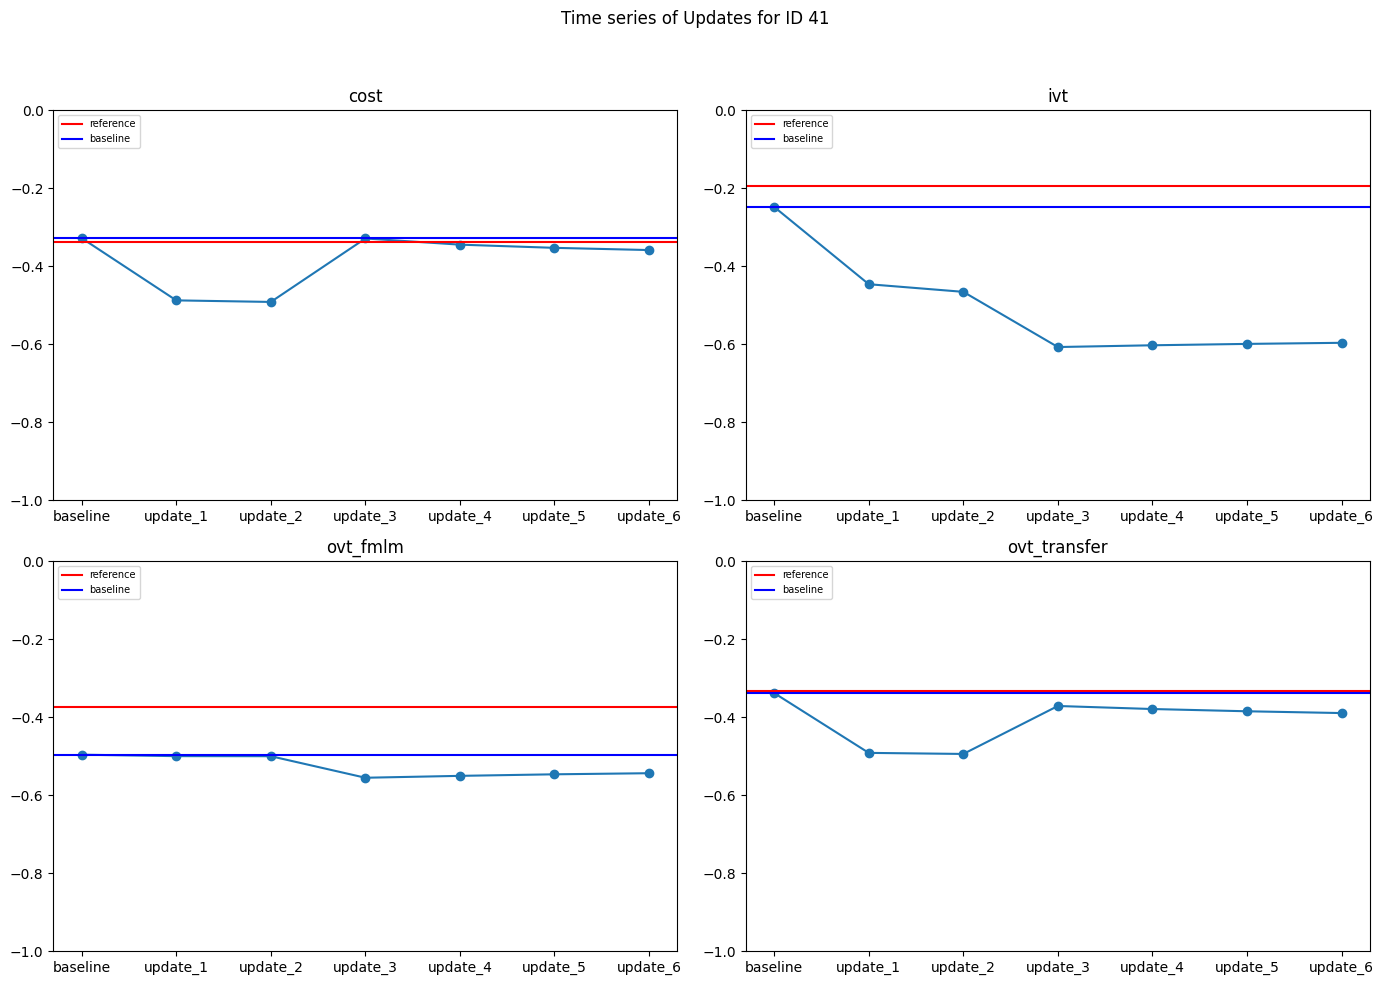

In [ ]:
# ID 41 / Both correct / survey block 2 & run 7
# 실제 선택 B
# cost, ovt_transfer는 B가 더 좋고 ivt, ovt_fmlm은 A가 더 좋은 상황에서
# ID 41의 민감도가 ivt랑 ovt_fmlm만 높아졌고 결과적으로 B를 더 높은 확률로 선택함
plot_prob_change(mean_df_list,41)
plot_updated_parameters(mean_df_list,41)

### (3) Only ref correct인 경우

In [ ]:
compare_ref_updated[(compare_ref_updated.survey_block==4)&(compare_ref_updated.result=='Only ref correct')].reset_index(drop=True)

,ID,survey_block,run,cost_diff,ivt_diff,ovt_fmlm_diff,ovt_transfer_diff,choice,ref_prob,ref_choice,updated_prob,updated_choice,ref_result,updated_result,result
0,140,4,8,-5.0,0,6,-2,1,0.528097,1,0.420245,0,True,False,Only ref correct


reference [0.53]
updated [0.34 0.5  0.52 0.41 0.41 0.42 0.42]


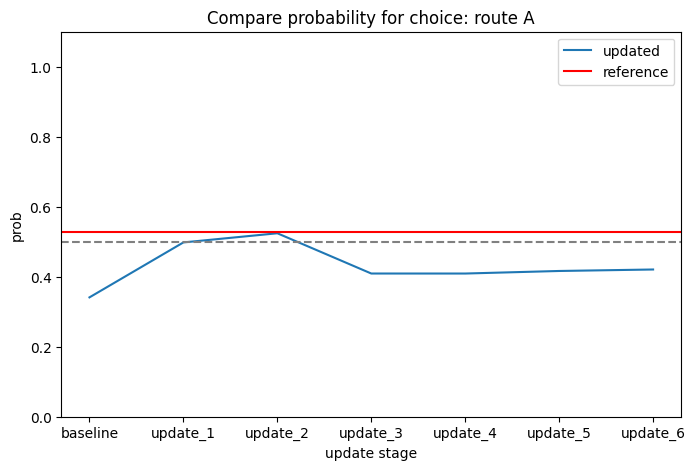

cost
reference -0.3377
baseline -0.3279
updated [-0.3279 -0.3201 -0.3611 -0.3035 -0.3183 -0.3245 -0.3287]

ivt
reference -0.195
baseline -0.2479
updated [-0.2479 -0.6503 -0.6449 -0.6362 -0.6306 -0.6294 -0.6274]

ovt_fmlm
reference -0.3732
baseline -0.496
updated [-0.496  -0.426  -0.4456 -0.4875 -0.4992 -0.4989 -0.4992]

ovt_transfer
reference -0.3316
baseline -0.3379
updated [-0.3379 -0.4729 -0.4816 -0.5193 -0.5172 -0.5161 -0.5151]



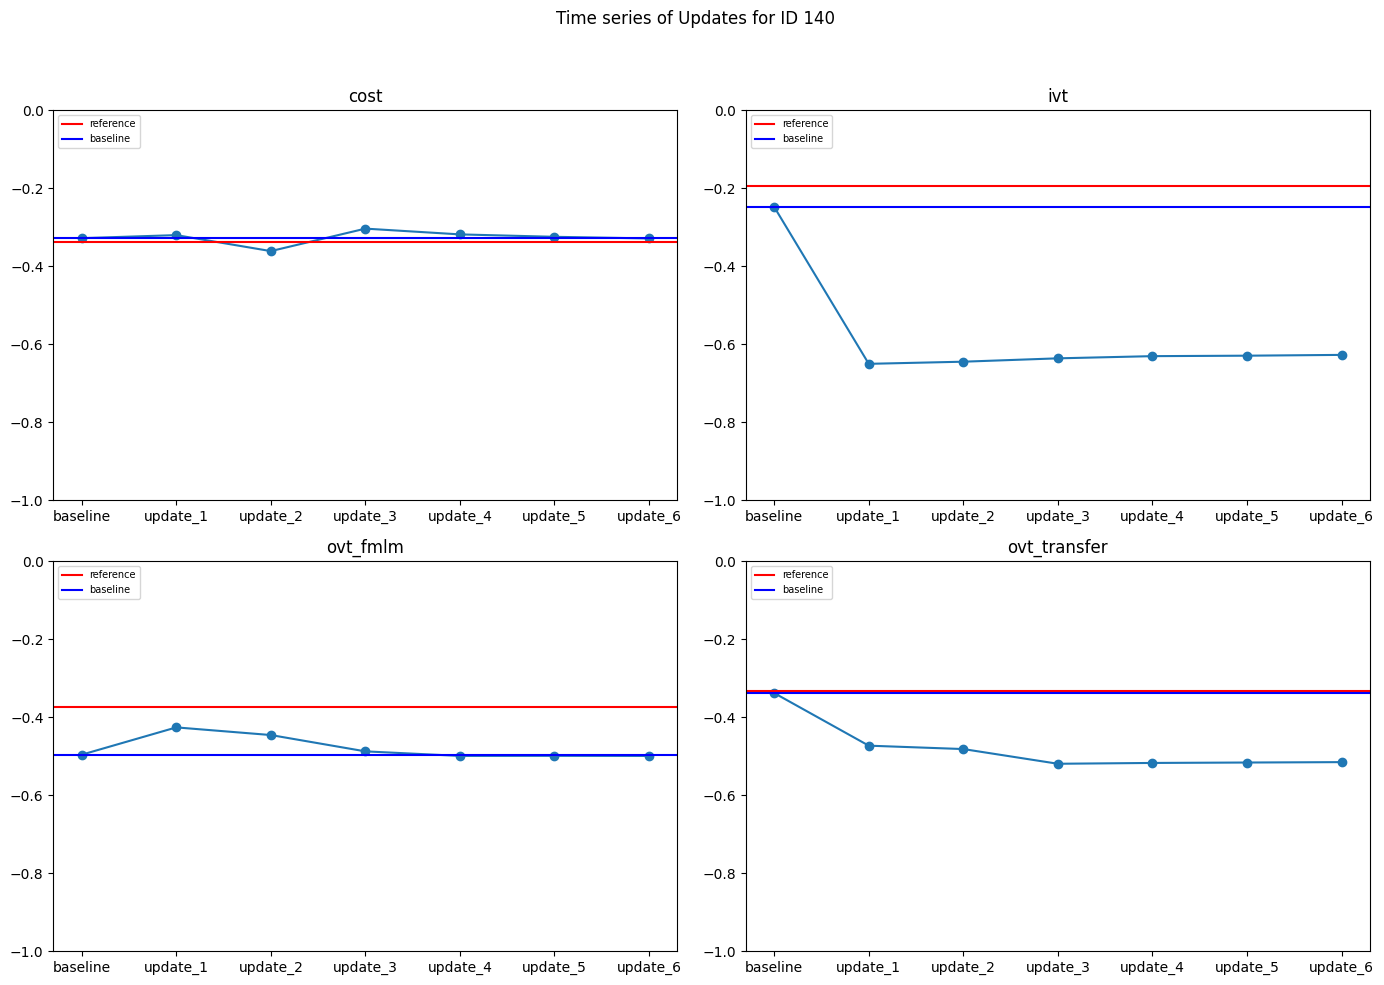

In [ ]:
# ID 140 - block 4, run 8
plot_prob_change(mean_df_list,140)
plot_updated_parameters(mean_df_list,140)

### (4) Neither Correct인 경우
- 대부분의 updated model 결과가 해석이 안되는 결과
- 그냥 한계로 남겨놓자.

In [ ]:
compare_ref_updated[(compare_ref_updated.survey_block==4)&(compare_ref_updated.result=='Neither correct')].reset_index(drop=True)

,ID,survey_block,run,cost_diff,ivt_diff,ovt_fmlm_diff,ovt_transfer_diff,choice,ref_prob,ref_choice,updated_prob,updated_choice,ref_result,updated_result,result
0,83,4,8,-5.0,0,6,-2,0,0.528097,1,0.804657,1,False,False,Neither correct
1,106,4,3,5.0,0,-2,-2,1,0.430777,0,0.375770,0,False,False,Neither correct
2,147,4,6,5.0,-10,-4,0,0,0.852477,1,0.840774,1,False,False,Neither correct
3,182,4,2,2.5,-10,6,2,1,0.142246,0,0.068771,0,False,False,Neither correct
4,184,4,2,2.5,-10,6,2,1,0.142246,0,0.113767,0,False,False,Neither correct
5,185,4,7,-5.0,10,0,0,1,0.435010,0,0.387107,0,False,False,Neither correct
6,193,4,3,5.0,0,-2,-2,1,0.430777,0,0.453211,0,False,False,Neither correct


reference [0.43]
updated [0.51 0.25 0.37 0.37 0.35 0.46 0.45]


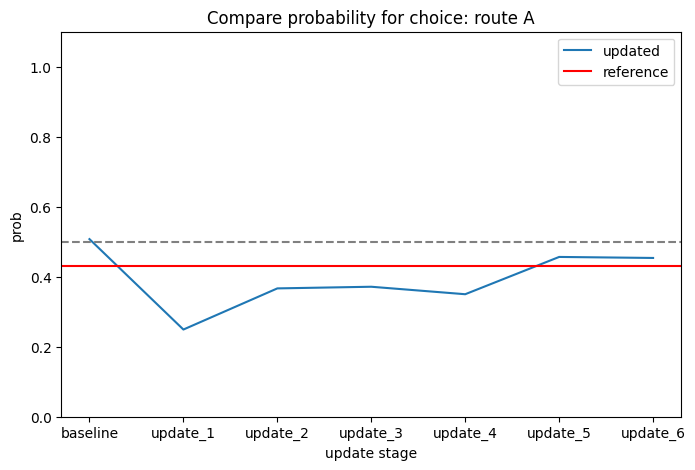

cost
reference -0.3377
baseline -0.3279
updated [-0.3279 -0.6149 -0.5204 -0.5208 -0.5386 -0.449  -0.4528]

ivt
reference -0.195
baseline -0.2479
updated [-0.2479 -0.1602 -0.2044 -0.2067 -0.2105 -0.2488 -0.2492]

ovt_fmlm
reference -0.3732
baseline -0.496
updated [-0.496  -0.5683 -0.5857 -0.5848 -0.5779 -0.5732 -0.5743]

ovt_transfer
reference -0.3316
baseline -0.3379
updated [-0.3379 -0.4161 -0.4413 -0.4532 -0.4582 -0.4615 -0.4638]



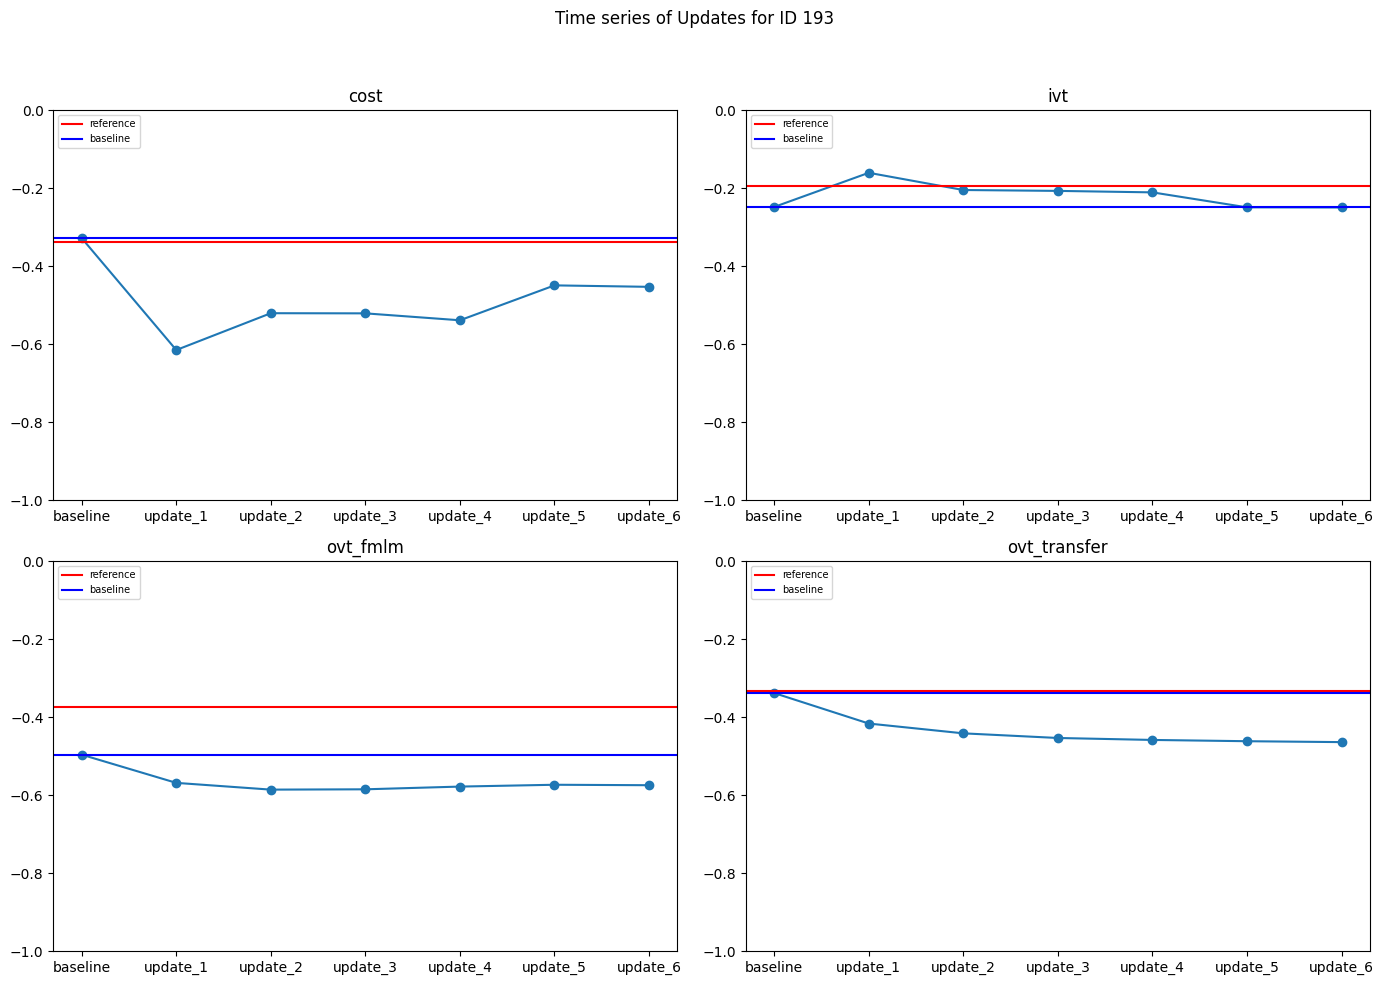

In [ ]:
# ID 193 - block 4, run 3
# 실제 선택 A
plot_prob_change(mean_df_list,193)
plot_updated_parameters(mean_df_list,193)

reference [0.53]
updated [0.34 0.52 0.59 0.77 0.82 0.81 0.8 ]


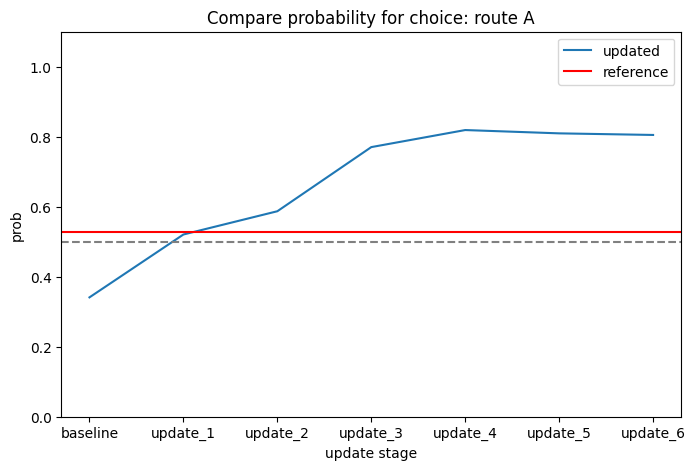

cost
reference -0.3377
baseline -0.3279
updated [-0.3279 -0.4249 -0.476  -0.6464 -0.5646 -0.5659 -0.5605]

ivt
reference -0.195
baseline -0.2479
updated [-0.2479 -0.4764 -0.4826 -0.2918 -0.4405 -0.4406 -0.4507]

ovt_fmlm
reference -0.3732
baseline -0.496
updated [-0.496  -0.5042 -0.5029 -0.5023 -0.3703 -0.383  -0.3851]

ovt_transfer
reference -0.3316
baseline -0.3379
updated [-0.3379 -0.4908 -0.4938 -0.4949 -0.453  -0.4568 -0.4619]



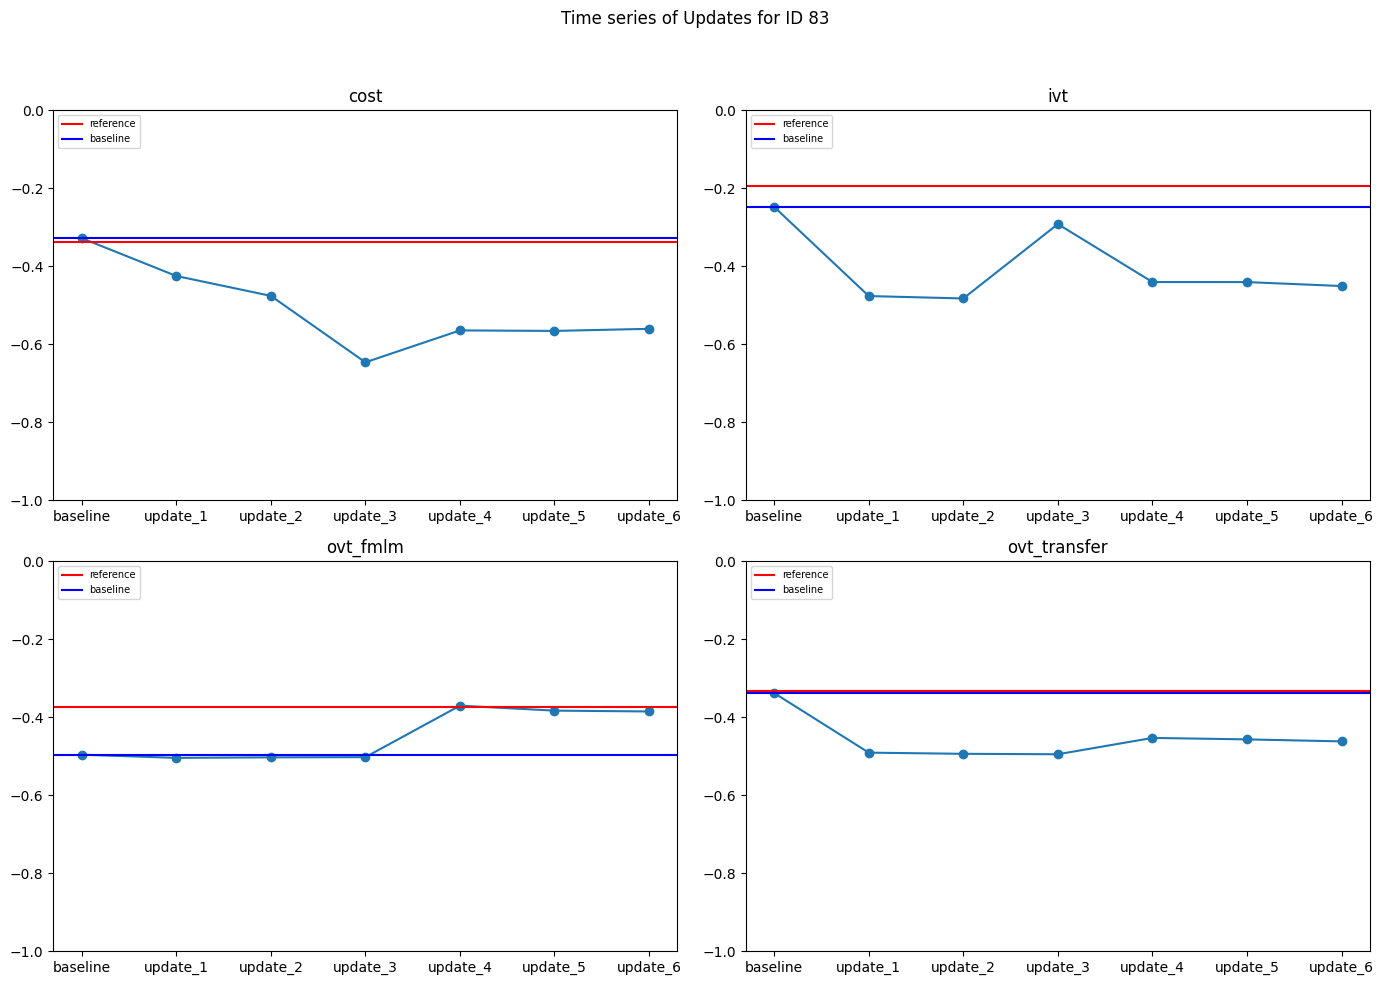

In [ ]:
# ID 83 - block 4, run 8
# 실제 선택 B
plot_prob_change(mean_df_list,83)
plot_updated_parameters(mean_df_list,83)

In [ ]:
compare_ref_updated.shape

(204, 15)

In [ ]:
compare_ref_updated[['survey_block','run']].value_counts()

# 2-2가 가장 많음
# 우리가 보던 4-8도 6개

survey_block  run
2             2      12
4             6      11
2             8      11
1             4      10
4             7       8
1             6       8
              7       8
4             2       8
3             6       8
1             1       7
4             4       7
              3       7
2             6       7
3             5       7
              3       6
              7       6
4             8       6
1             2       6
2             4       6
              1       6
1             8       6
              5       6
3             2       5
2             7       5
4             1       5
              5       5
2             5       4
1             3       4
3             8       3
              1       3
2             3       2
3             4       1
Name: count, dtype: int64

In [ ]:
ovt_transfer_mean_update_result.iloc[83,:]

,83
ID,83
baseline,-0.337946
update_1,-0.490791
update_2,-0.493802
update_3,-0.494916
update_4,-0.45301
update_5,-0.456754
update_6,-0.461912


## Block 4 말고 나머지 해석

### 1-4

reference [0.43]
updated [0.39 0.39 0.4  0.4  0.39 0.4  0.4 ]


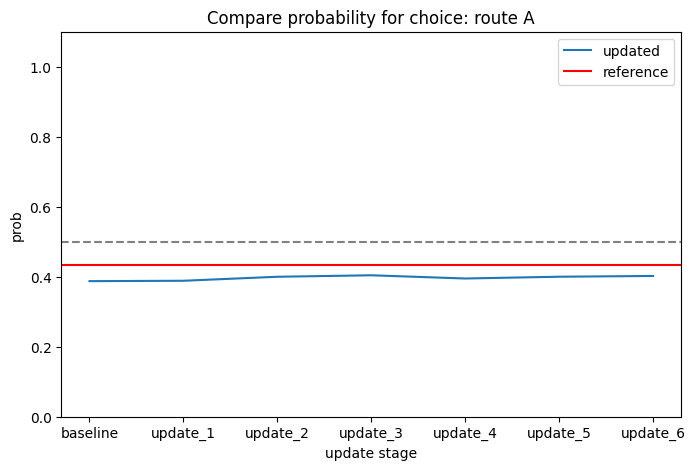

reference [0.43]
updated [0.39 0.67 0.61 0.6  0.65 0.64 0.67]


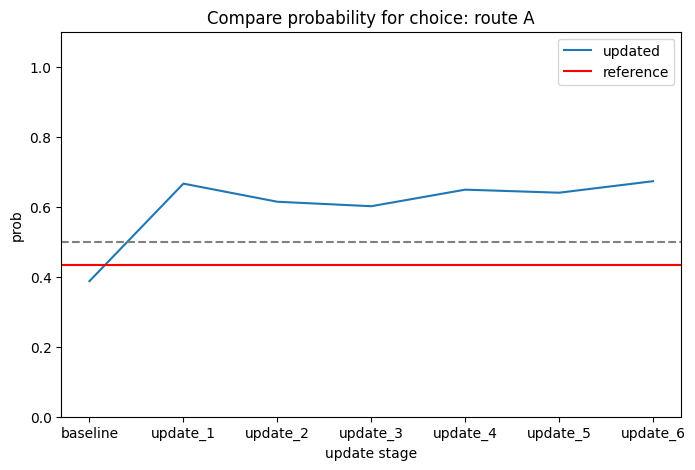

reference [0.43]
updated [0.39 0.44 0.44 0.44 0.44 0.56 0.52]


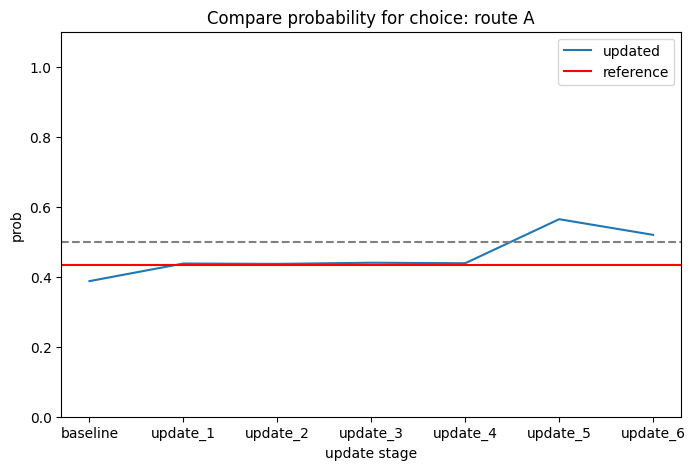

reference [0.43]
updated [0.39 0.45 0.44 0.44 0.43 0.42 0.42]


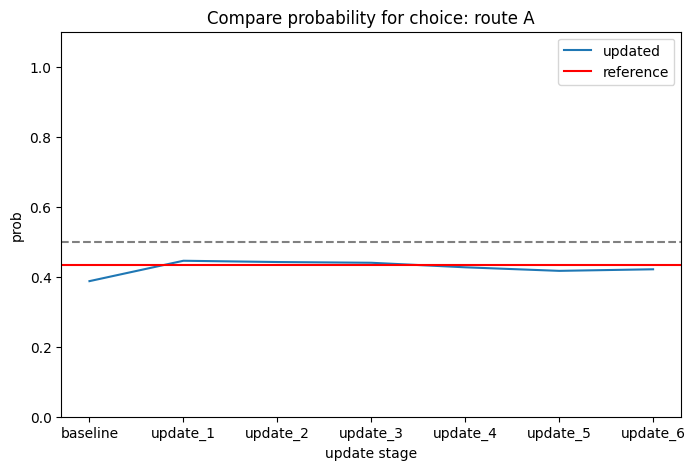

In [ ]:
compare_ref_updated[(compare_ref_updated.survey_block==1)&(compare_ref_updated.run==4)&(compare_ref_updated.result=='Both correct')] #145
compare_ref_updated[(compare_ref_updated.survey_block==1)&(compare_ref_updated.run==4)&(compare_ref_updated.result=='Only updated correct')] #26
compare_ref_updated[(compare_ref_updated.survey_block==1)&(compare_ref_updated.run==4)&(compare_ref_updated.result=='Only ref correct')] #125
compare_ref_updated[(compare_ref_updated.survey_block==1)&(compare_ref_updated.run==4)&(compare_ref_updated.result=='Neither correct')] #71

ID = [145, 26, 125, 71]
for id in ID:
  plot_prob_change(mean_df_list,id)

cost
reference -0.3377
baseline -0.3279
updated [-0.3279 -0.5675 -0.551  -0.5437 -0.5434 -0.5403 -0.5381]

ivt
reference -0.195
baseline -0.2479
updated [-0.2479 -0.4558 -0.4684 -0.4832 -0.5143 -0.5194 -0.5189]

ovt_fmlm
reference -0.3732
baseline -0.496
updated [-0.496  -0.4904 -0.507  -0.5088 -0.5078 -0.5072 -0.5067]

ovt_transfer
reference -0.3316
baseline -0.3379
updated [-0.3379 -0.486  -0.496  -0.4967 -0.4865 -0.4895 -0.4901]



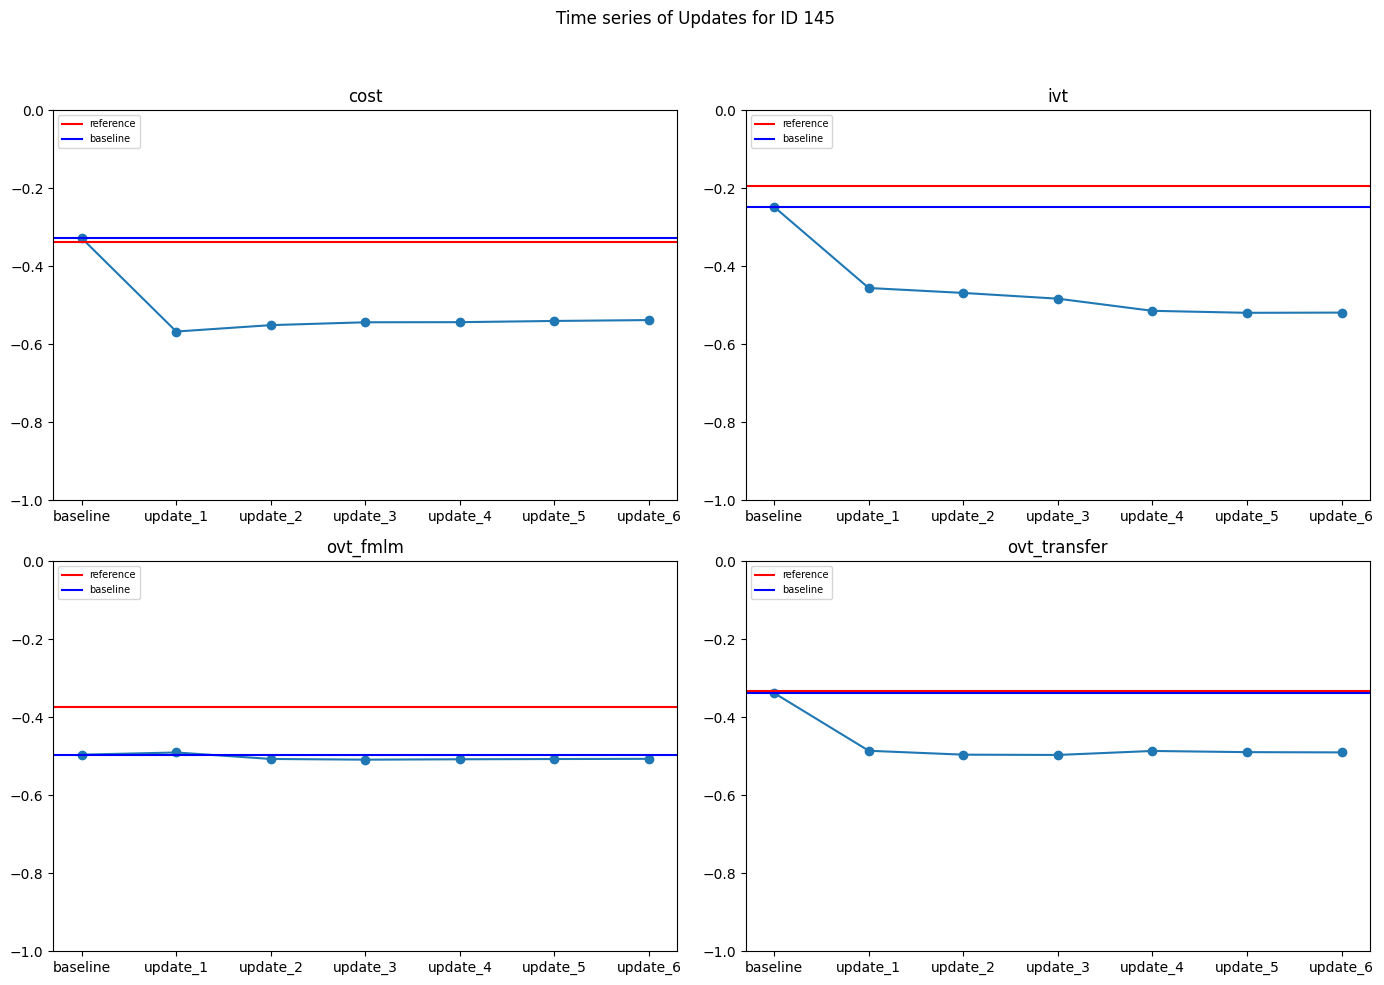

cost
reference -0.3377
baseline -0.3279
updated [-0.3279 -0.3337 -0.3758 -0.3919 -0.2881 -0.2963 -0.1935]

ivt
reference -0.195
baseline -0.2479
updated [-0.2479 -0.1423 -0.1676 -0.1813 -0.1698 -0.1722 -0.1108]

ovt_fmlm
reference -0.3732
baseline -0.496
updated [-0.496  -0.4998 -0.5102 -0.5085 -0.5707 -0.5711 -0.6177]

ovt_transfer
reference -0.3316
baseline -0.3379
updated [-0.3379 -0.6305 -0.6058 -0.6016 -0.6184 -0.6142 -0.6098]



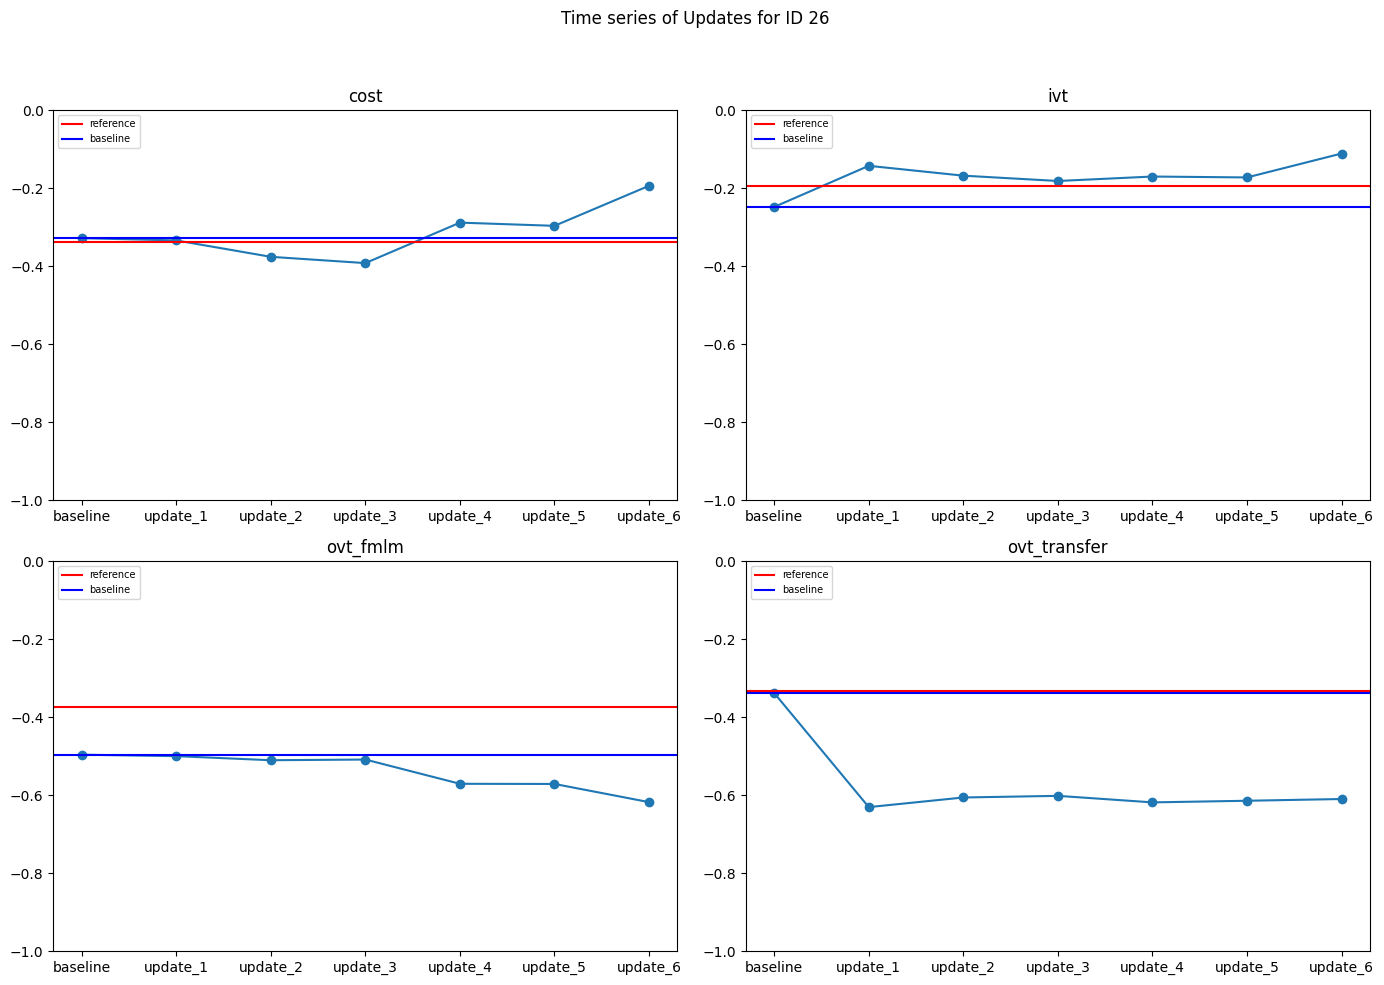

cost
reference -0.3377
baseline -0.3279
updated [-0.3279 -0.4863 -0.4906 -0.4923 -0.4932 -0.2907 -0.3141]

ivt
reference -0.195
baseline -0.2479
updated [-0.2479 -0.4468 -0.4622 -0.4782 -0.4884 -0.3696 -0.4297]

ovt_fmlm
reference -0.3732
baseline -0.496
updated [-0.496  -0.4997 -0.5131 -0.5109 -0.5122 -0.6025 -0.5971]

ovt_transfer
reference -0.3316
baseline -0.3379
updated [-0.3379 -0.4908 -0.4991 -0.5024 -0.5021 -0.5472 -0.5141]



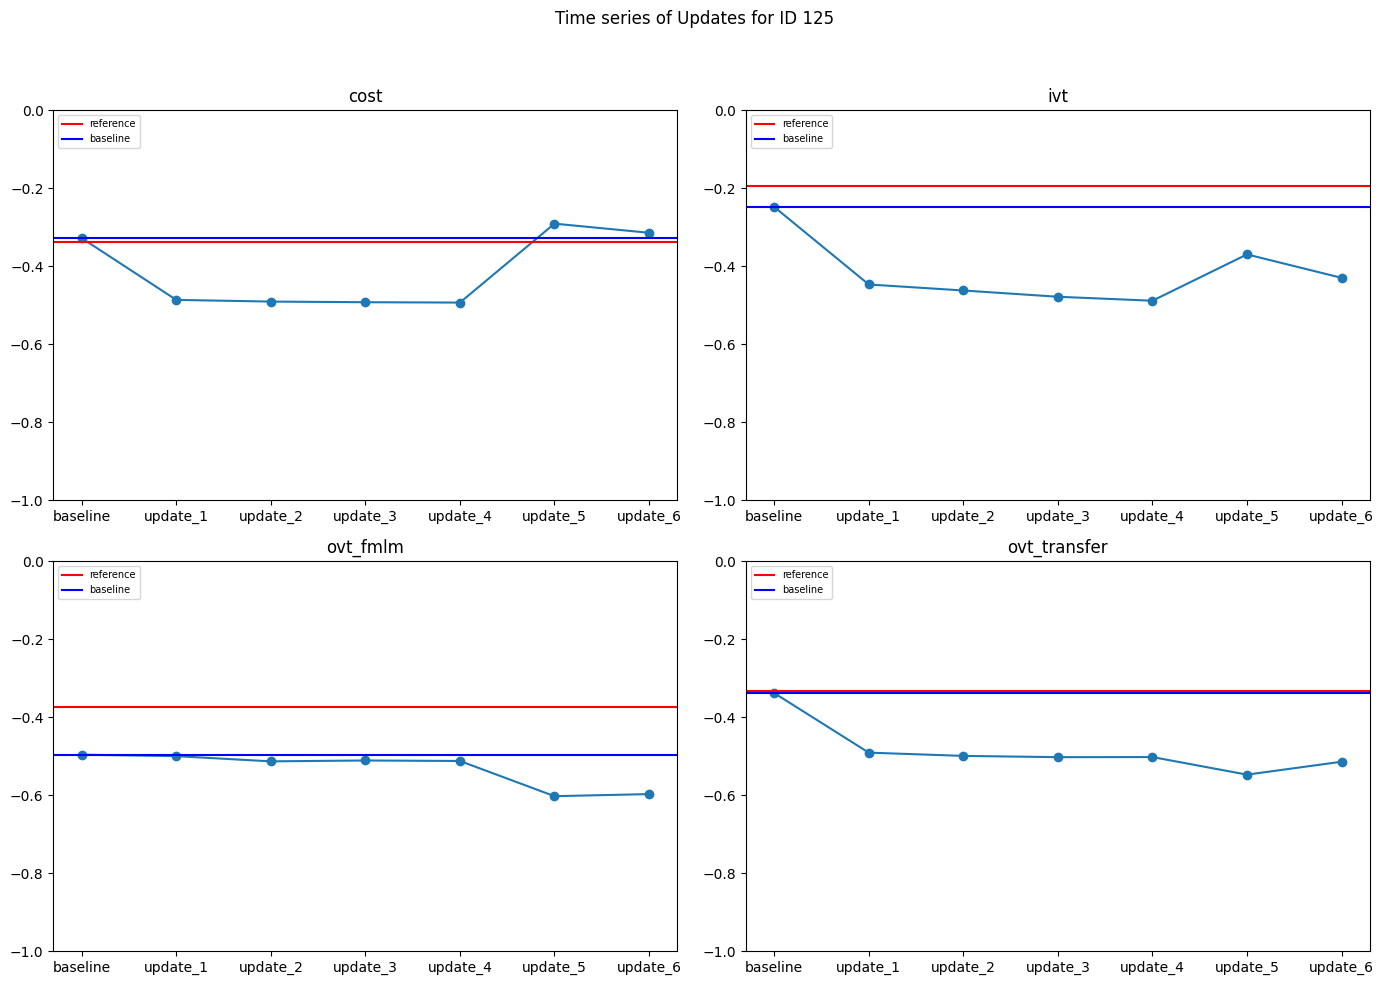

cost
reference -0.3377
baseline -0.3279
updated [-0.3279 -0.4832 -0.4886 -0.4906 -0.5132 -0.5156 -0.5148]

ivt
reference -0.195
baseline -0.2479
updated [-0.2479 -0.4696 -0.4781 -0.4909 -0.5012 -0.5261 -0.4209]

ovt_fmlm
reference -0.3732
baseline -0.496
updated [-0.496  -0.4998 -0.513  -0.5136 -0.5054 -0.5049 -0.5616]

ovt_transfer
reference -0.3316
baseline -0.3379
updated [-0.3379 -0.4969 -0.5032 -0.5026 -0.4994 -0.4903 -0.5227]



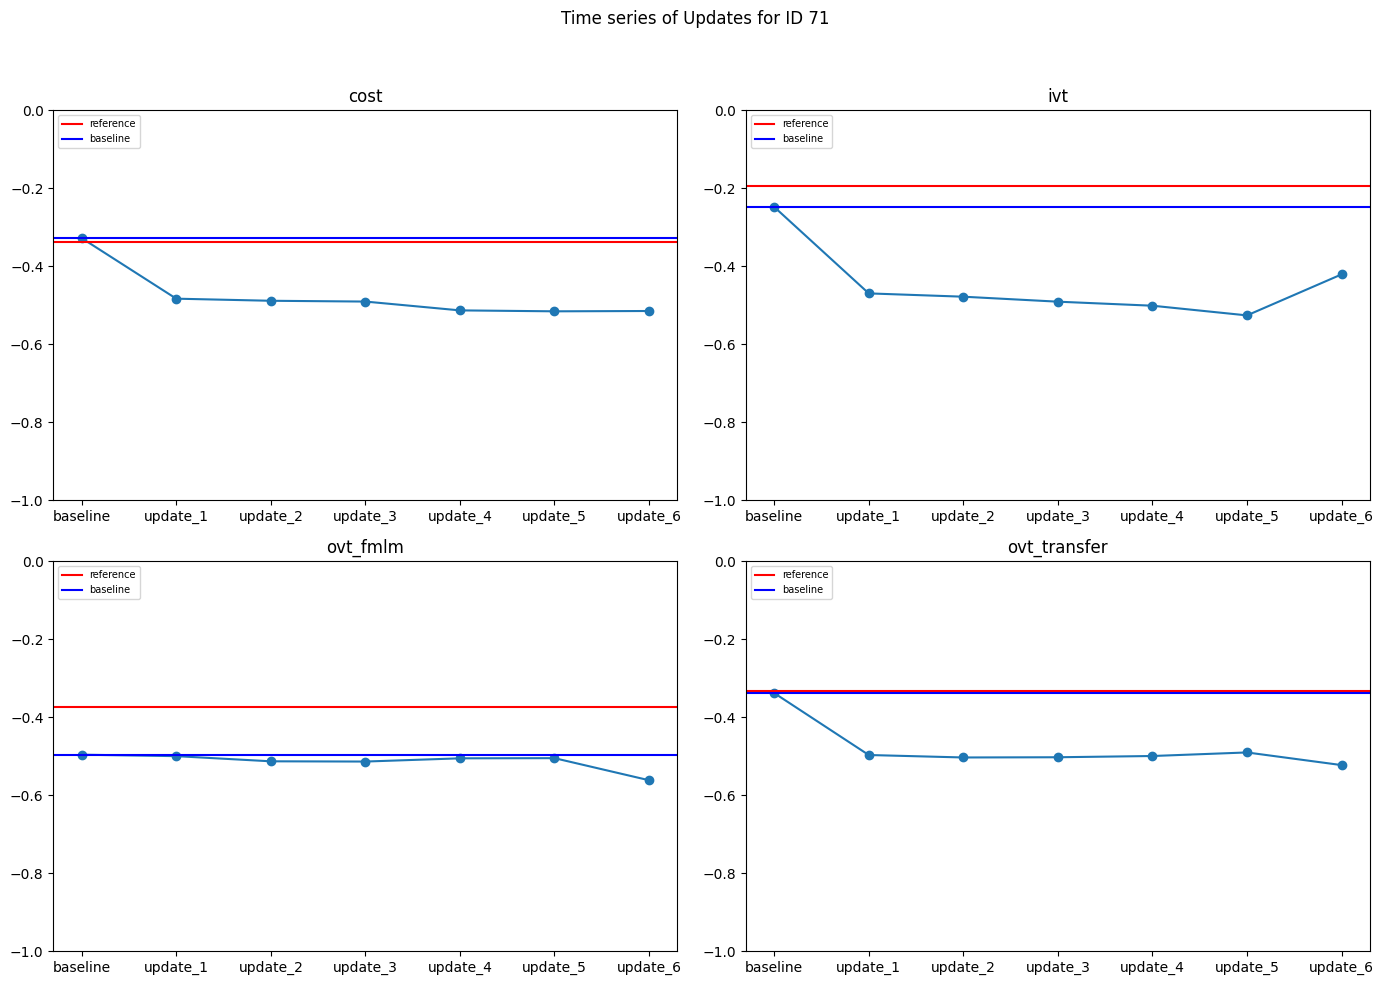

In [ ]:
for id in ID:
  plot_updated_parameters(mean_df_list,id)

### 1-8

reference [0.83]
updated [0.86 0.98 0.98 0.97 0.97 0.97 0.96]


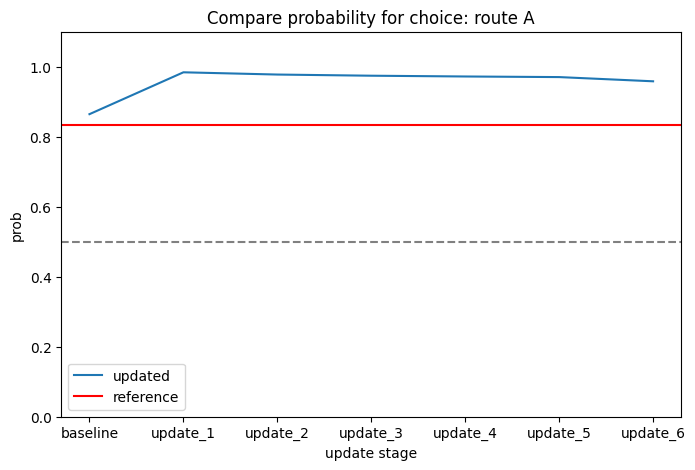

reference [0.83]
updated [0.86 0.58 0.53 0.45 0.43 0.41 0.43]


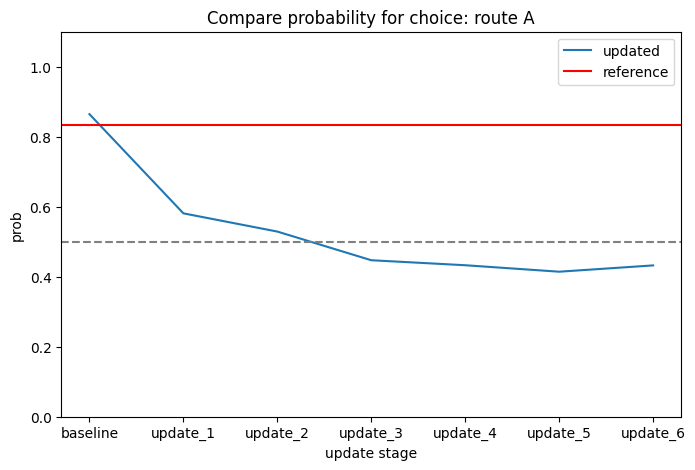

reference [0.83]
updated [0.86 0.67 0.61 0.51 0.49 0.49 0.47]


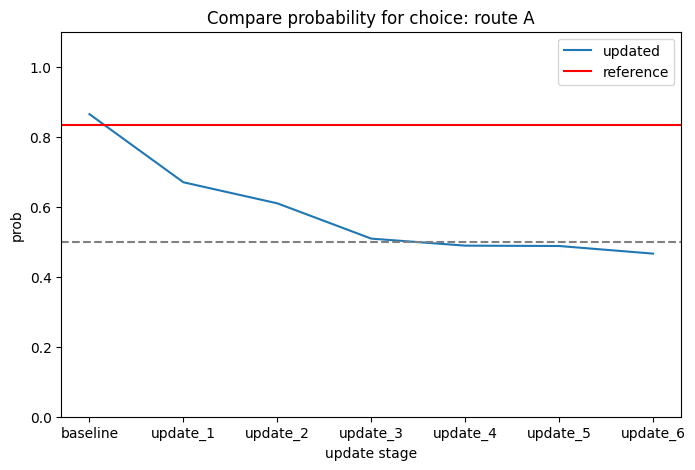

In [ ]:
compare_ref_updated[(compare_ref_updated.survey_block==1)&(compare_ref_updated.run==8)&(compare_ref_updated.result=='Both correct')] #142
compare_ref_updated[(compare_ref_updated.survey_block==1)&(compare_ref_updated.run==8)&(compare_ref_updated.result=='Only updated correct')] #2
compare_ref_updated[(compare_ref_updated.survey_block==1)&(compare_ref_updated.run==8)&(compare_ref_updated.result=='Only ref correct')] #201

ID = [142, 2, 201]
for id in ID:
  plot_prob_change(mean_df_list,id)

### 2-8

reference [0.71]
updated [0.74 0.57 0.72 0.69 0.96 0.96 0.95]


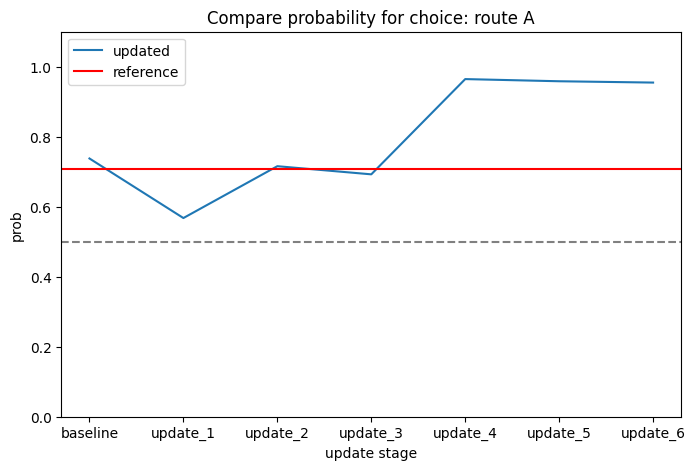

reference [0.71]
updated [0.74 0.42 0.44 0.49 0.49 0.49 0.49]


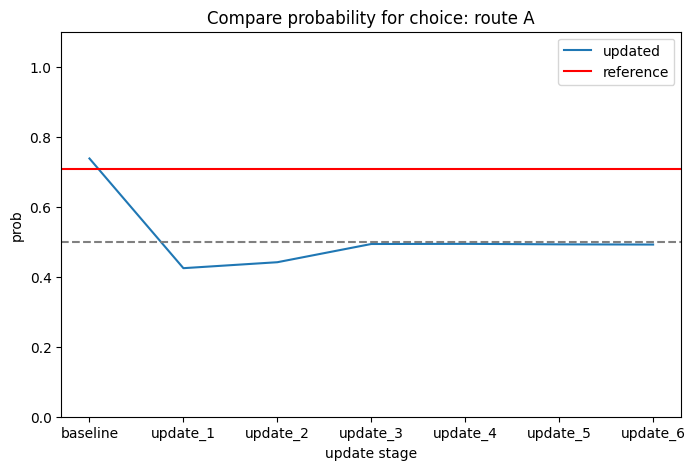

reference [0.71]
updated [0.74 0.44 0.46 0.46 0.47 0.47 0.49]


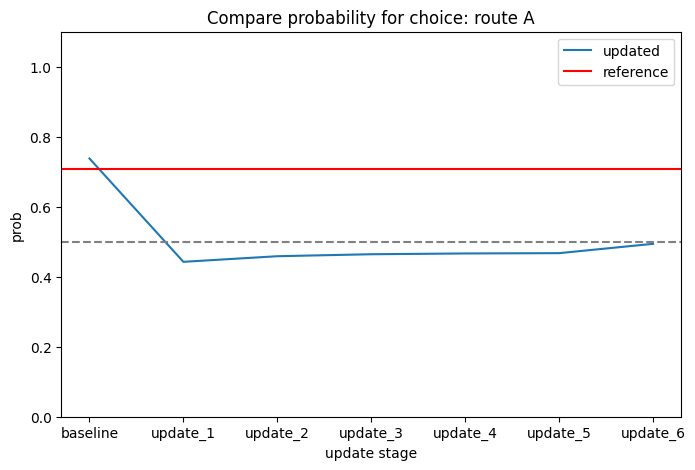

reference [0.71]
updated [0.74 0.57 0.55 0.53 0.56 0.54 0.64]


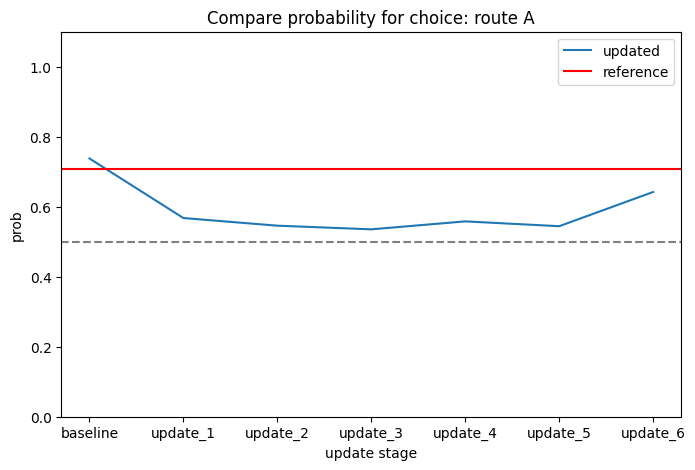

In [ ]:
compare_ref_updated[(compare_ref_updated.survey_block==2)&(compare_ref_updated.run==8)&(compare_ref_updated.result=='Both correct')] #91
compare_ref_updated[(compare_ref_updated.survey_block==2)&(compare_ref_updated.run==8)&(compare_ref_updated.result=='Only updated correct')] #150
compare_ref_updated[(compare_ref_updated.survey_block==2)&(compare_ref_updated.run==8)&(compare_ref_updated.result=='Only ref correct')] #6
compare_ref_updated[(compare_ref_updated.survey_block==2)&(compare_ref_updated.run==8)&(compare_ref_updated.result=='Neither correct')] #115

ID = [91, 150, 6, 115]
for id in ID:
  plot_prob_change(mean_df_list,id)